In [100]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time 
import csv

In [101]:
# ! Remove Warnings  for SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [102]:
# %run Data_handle.ipynb

In [103]:
all_data= pd.read_excel('output.xlsx')
# usecols='A:I'
#### Calculates the Gap Time
# all_data.loc[:,'Seq No':'Class'].head()
all_data['Date + Time'] = pd.to_datetime(all_data['Date + Time'])
all_data['Date'] = pd.to_datetime(all_data['Date + Time']).dt.date

all_data['Same Bound'] = all_data['Bound'] == all_data['Bound'].shift(1)
all_data['Same Lane'] = all_data['Lane'] == all_data['Lane'].shift(1)    
# if all_data.loc['Bound'].eq(all_data.loc['Bound'].shift(1)) and all_data.loc['Lane'].eq(all_data.loc['Lane'].shift(1)):
#     all_data['Gap Time'] = all_data['Speed'] * (all_data['Date + Time'].shift(1) - all_data['Date + Time'])
# else:
#     all_data['Gap Time'] = pd.NA


    
# filter1 = all_data['Same Bound'] == True
# filter2 = all_data['Same Lane'] == True
# not_filter1 = all_data['Same Bound'] == False
# not_filter2 = all_data['Same Lane'] == False

# change = all_data['Date + Time'].diff().dt.seconds
# all_data['Speed'] * (all_data['Date + Time'].shift(1) - all_data['Date + Time'])

all_data.loc[(all_data['Same Bound'] == True) & (all_data['Same Lane'] == True), 'Gap Time'] = all_data['Date + Time'].diff().dt.seconds
all_data.loc[all_data['Same Bound'] == False, 'Gap Time'] = pd.NA
all_data.loc[all_data['Same Lane'] == False, 'Gap Time'] = pd.NA
# all_data = all_data.fillna(all_data['Gap Time'].mean())

cols = ['Gap Time']
all_data.loc[:,cols] = all_data.loc[:,cols].bfill()



In [ ]:
for i in range(11,27):
    num = (i - 7) // 2
    if i % 2 == 0:
        new_column_name = 'Axle Spacing ' + str(num)
    else:
        new_column_name = 'Axle Weight ' + str(num)
    column_name = 'Unnamed: ' + str(i)
    print(f'{column_name=}, {new_column_name=}')
    all_data.rename(columns={column_name: new_column_name}, inplace=True)
all_data.columns


# Generation of the Stream of Truck Taffic in each Direction 
According to https://arrow.tudublin.ie/cgi/viewcontent.cgi?article=1045&context=engschcivart

#### Pseudo Code
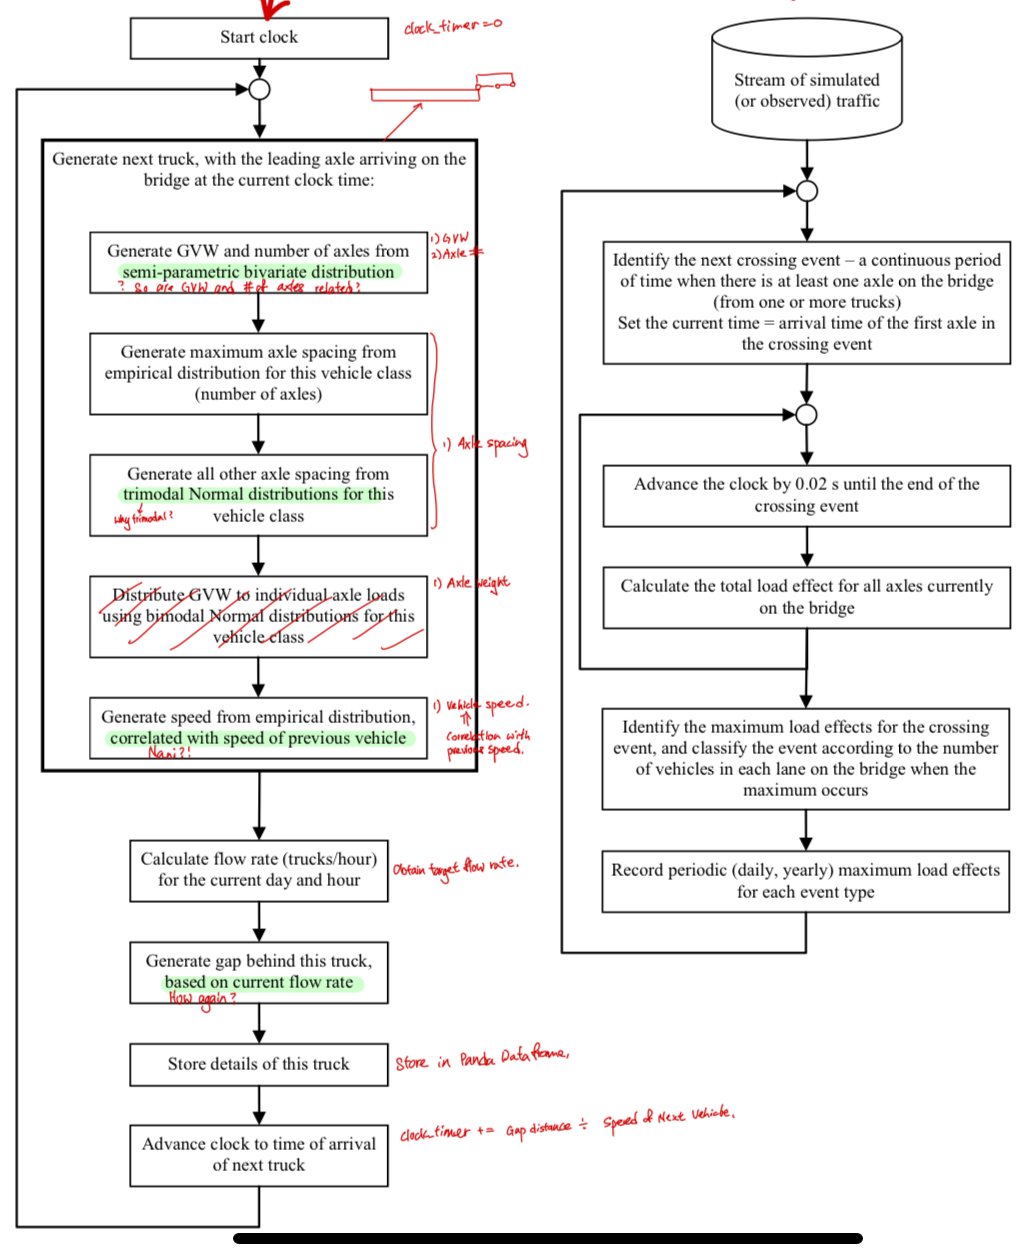

## Imported From 'Data_handle.ipynb'

In [ ]:
from datetime import time as t

def vehicular_flow_in_hours_setup():
        
    def generate_time(time_list):
        for h in range(24):
            time_list.append(t(h).strftime("%H"))
        return

    # Create the Time column, where it is in the string format of hour:minute in 1 minute increments
    all_data['Time'] = all_data['Date + Time'].dt.floor('h')
    all_data['Time'] = all_data['Time'].dt.strftime("%H")

    # Make a time list to store all the x data from 00:00 to 23:59
    time_list = []
    generate_time(time_list)
    dict = {"Time": time_list}

    # Loops over the number of recorded date
    date_list = all_data['Date'].unique()
    for date in date_list:
        vehicle_flow = []
        # Loops over each minute
        for time in time_list:
            # Tallies the number of vehicle that is recorded in that minute. -> convert the unit from veh/min to veh/hr
            # ? Times 60 for the total numebr of cars to convert: cars per min to cars per hour
            tmp = all_data[(all_data['Date']==date) & (all_data['Time']==time)]
            hourly_flow = len(tmp.index)
            if hourly_flow < 100: 
                hourly_flow = 0
            vehicle_flow.append(hourly_flow)
        dict[date] = vehicle_flow
    # print()
    VF_testing = pd.DataFrame(dict)

    # Finding the Average Values
    VF_testing['Total'] = VF_testing.iloc[:,1:6].sum(axis=1)
    VF_testing['Unique Dates'] = VF_testing.iloc[:,1:6].astype(bool).sum(axis=1)

    VF_testing['Average'] = VF_testing['Total'] / VF_testing['Unique Dates']
    VF_testing['Average'] =  VF_testing['Average'].fillna(0)
    
    return VF_testing, time_list, date_list

def average_vehicular_flow():
    VF_testing, time_list, date_list = vehicular_flow_in_hours_setup()
    np_vehicular_flow = VF_testing['Average'].to_numpy() 
    np_time_list = time_list
    print(f'{np_vehicular_flow=}')
    print(f'{np_time_list=}')
    return None



def vehicular_flow_in_hours_with_average_and_scatter():

    VF_testing, time_list, date_list = vehicular_flow_in_hours_setup()

    # graph plot the average value
    plt.plot(time_list, VF_testing['Average'],'.-', label='Average')
    print(VF_testing['Average'])

    # Scatter Plot
    for date in date_list:
        # removes the time data for when there is no vehicle recorded
        tmp = np.array(VF_testing[date].astype(float))
        tmp[tmp==0] = np.nan
        
        plt.scatter(VF_testing['Time'], tmp, label=date)

    plt.xticks(time_list, rotation=70)
    plt.legend(loc=0)
    plt.grid()
    plt.xlabel('Time of Day (24 hour format)')
    plt.ylabel('Vehicular Flow (veh/h)')
    plt.title('Hourly Vehicular Flow per Lane Across Different Times of Day')
    plt.tight_layout()
    plt.show()
    return 
vehicular_flow_in_hours_with_average_and_scatter()

# Setup Function 

### For generate_daily_vehicle_stream()

In [167]:
# * Function Template for finding distribution from dataset, plotting the dataset, and interpolating data
from importlib import reload
import random
from collections import Counter

database = {}

def filter_all_data(vehicle_class_column_name, vehicle_class_value, df=all_data):
    return df[df[vehicle_class_column_name] == vehicle_class_value]

# def obtain_distribution(total_weight_column_name, df=all_data):
#     # Counts the values within the subset that matches the 
#     # print(f'{df[total_weight_column_name]=}')
#     tmp = pd.DataFrame(df[total_weight_column_name].value_counts())

#     tmp = tmp.sort_values(total_weight_column_name).reset_index()

#     tmp.columns = [total_weight_column_name, 'Count']
#     total_rows = tmp['Count'].sum()
    
#     # calculate the percentage and cumulative probability for each dataset
#     tmp['Percentage'] = tmp['Count'] / total_rows
#     tmp['Cumulative Probability'] = tmp['Percentage'].cumsum()

#     return tmp[[total_weight_column_name, 'Cumulative Probability']]

# optimised by ChatGPT
def obtain_distribution(total_weight_column_name: str, df: pd.DataFrame = all_data):
    counts = df.groupby(total_weight_column_name).size().reset_index(name='Count')
    total_rows = counts['Count'].sum()
    counts['Percentage'] = counts['Count'] / total_rows
    # counts['Cumulative Probability'] = (counts['Count'] / total_rows).cumsum()

    counts['Cumulative Probability'] = counts['Percentage'].cumsum()
    # * Numpy
    # np_cumu_distribution = counts[[total_weight_column_name, 'Cumulative Probability']].to_numpy().T
    # return np_cumu_distribution

    # * Pandas
    # output = counts.loc[:,[total_weight_column_name,'Cumulative Probability' ]]    
    output = counts.loc[:,[total_weight_column_name,'Percentage' ]]    
    return output

    




def add_unit(axis: str):
    if axis == 'Gap Time': 
        axis += ' (s)'
    elif axis == 'Total Weight': 
        axis += ' (kg)'
    elif axis == 'Speed': 
        axis += ' (km/h)'
    elif 'Axle Weight' in axis: 
        axis += ' (kg)'
    elif 'Axle Spacing' in axis: 
        axis += ' (mm)'
    return axis

def plot_distribution(df:pd.DataFrame, additional_string:str = ''):
    import matplotlib.pyplot as plt 

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot()

    ax.set_title(f'For Cars of {additional_string}:',fontweight='bold')
    x_axis = df.columns[0]
    y_axis = df.columns[-1]

    tmp_x_axis = df.columns[0]

    tmp_y_axis = df.columns[-1]

    if (x_axis == 'Bound')| (x_axis == 'Date + Time')| (x_axis == 'Seq No')| (x_axis == 'Lane')| (x_axis == 'Class')| (x_axis == 'No of Axle'): 
        ax.bar(df[x_axis], df[y_axis])
    else:
        # ax.scatter(df[x_axis], df[y_axis], s=20)
        ax.plot(df[x_axis], df[y_axis],color='C0', marker='o', linestyle='-' )

    ax=reload(plt)
    if y_axis == 'Cumulative Probability':
        fig.suptitle(f'CDF of {x_axis}')
    else:
        fig.suptitle(f'{x_axis} against {y_axis}')

    # print(f'{df.iloc[-1,0]}=')
    ax.xlim(0,df.iloc[-1,0])
    # Show the major grid and style it slightly.
    plt.grid(True, which='both')
    plt.grid(which='major', color='black', linewidth=0.8)
    # Show the minor grid as well. Style it in very light gray as a thin,
    # dotted line.
    plt.grid(which='minor', color='black', linestyle=':', linewidth=1)
    # Make the minor ticks and gridlines show.
    plt.minorticks_on()

    plt.legend(loc=0)
    
    x_axis = add_unit(x_axis)
    y_axis = add_unit(y_axis)

    ax.xlabel(x_axis)
    ax.ylabel(y_axis)

    # from pathlib import Path

    filename = f'Graphs/CPD_{additional_string}_{tmp_y_axis}_{tmp_x_axis}.png'
    # my_file = Path(filename)
    # if not my_file.is_file():
    # file exists
    plt.savefig(filename)
    # ax.show()

    # try:
    #     my_abs_path = my_file.resolve(strict=True)
    # except FileNotFoundError:
    #     # doesn't exist
    # # else:
    #     # exists

    return

# def generate_and_interpolate_value(dataframe: pd.DataFrame):
#     # print(f'{dataframe=}')
#     x_axis = dataframe.columns[0]
#     y_axis = dataframe.columns[-1]

#     # * Generate a random number between 0 and 1
#     random_prob = random.random()
#     # print(f'{random_prob = }')

#     # * Sort the dataframe by cumulative probability column
#     sorted_df = dataframe.sort_values(y_axis)

#     # * For Dicrete Data
#     if (x_axis == 'Bound')| (x_axis == 'Date + Time')| (x_axis == 'Seq No')| (x_axis == 'Lane')| (x_axis == 'Class')| (x_axis == 'No of Axle'): 
#         # print('It is discrete')

#         # * Loops over the number of data in the datframe
#         for index in range(len(dataframe[x_axis])):
#             random_prob -= dataframe.iloc[index,-1].astype(float)
#             if random_prob <= 0:
#                 interpolated_value = dataframe.iloc[index,0]
#                 break
                
#     # * For Continuous Data
#     else: 
#         # print('It is continuous')
#         # * Check if random number is larger than the largest value
#         if (random_prob <= sorted_df.head(1)[y_axis].astype(float)).values:
#             return sorted_df.head(1)[x_axis]
        
#         # * Check if random number is smaller than the smallest value
#         if (random_prob >= sorted_df.tail(1)[y_axis].astype(float)).values:
#             return sorted_df.tail(1)[x_axis]

#         # * Interpolated between the closest two data
#         # * Find the closest value values based on the random probability
#         closest_values = []
#         closest_values.append(sorted_df[(sorted_df[y_axis] <= random_prob)].tail(1)[x_axis].values[0])
#         closest_values.append(sorted_df[(sorted_df[y_axis] >= random_prob)].head(1)[x_axis].values[0])
#         # print(f'{closest_values=}')

#         # * Calculate the value value using linear interpolation
#         interpolated_value = closest_values[0] + (closest_values[1] - closest_values[0]) * random_prob


#     # * Useful!
#     # print(f'{random_prob = }, {interpolated_value = }')

#     return interpolated_value

# Optimised by ChatGPT
def generate_and_interpolate_value(numpy_array: np.float64, total_weight_key: str):


    # TODO: Try to apply Vectorization to the function to speed it up. Current Speed = 0.003

    # x_axis = numpy_array.columns[0]
    # y_axis = numpy_array.columns[-1]

    # random_prob = random.random()

    # sorted_df = numpy_array.sort_values(y_axis)

    # if x_axis in ['Bound', 'Date + Time', 'Seq No', 'Lane', 'Class', 'No of Axle']:
    #     for index, row in numpy_array.iterrows():
    #         random_prob -= row[y_axis]
    #         if random_prob <= 0:
    #             interpolated_value = int(row[x_axis])
    #             break
    # else:
    #     if random_prob <= sorted_df.iloc[0][y_axis]:
    #         return sorted_df.iloc[0][x_axis]
    #     if random_prob >= sorted_df.iloc[-1][y_axis]:
    #         return sorted_df.iloc[-1][x_axis]

    #     closest_values = sorted_df.index.get_loc(sorted_df[(sorted_df[y_axis] <= random_prob) & (sorted_df[y_axis].shift(-1) >= random_prob)].index[0])
    #     closest_values = sorted_df.iloc[closest_values: closest_values+2]

    #     interpolated_value = float(closest_values.iloc[0][x_axis] + (closest_values.iloc[1][x_axis] - closest_values.iloc[0][x_axis]) * random_prob)

    # interpolated_value = np.random.choice(numpy_array[0], 1)[0]
    numpy_array = numpy_array.to_numpy().T


    random_prob = random.random()
    if total_weight_key in ['Bound', 'Date + Time', 'Seq No', 'Lane', 'Class', 'No of Axle']:
        sorter = np.argsort(numpy_array[1])
        tmp = np.searchsorted(numpy_array[1],[random_prob,],side='left', sorter=sorter)[0]

        interpolated_value = int(numpy_array[0][tmp])

    else:
        interpolated_value = np.interp(random_prob, numpy_array[1], numpy_array[0])


    return interpolated_value


def double_filter_and_generate_variable(vehicle_class_key1: str, vehicle_class_value1: int, vehicle_class_key2: str, vehicle_class_value2: int , total_weight_key: str, )-> float :
    
    # * Timesaving techniques!
    # Find the set of queries from the database to see if it is run before or not
    filter_key = f'{str(vehicle_class_key1)} = {str(vehicle_class_value1)} and {str(vehicle_class_key2)} = {str(vehicle_class_value2)}'
    database_key = f'{filter_key} {str(total_weight_key)}'
    # print(f'DATABASE KEY IS {database_key}')

    #* If it has been run before 

    if database_key in database:
        # * call the distribution from database
        distribution = database[database_key]
        # print(f'RECALLED DISTRIBUTION FROM DATABASE WITH KEY {database_key}')

    # * If it has never been run before
    else:
        # * generate the distribution from scratch
        # * filtering the data twice 
        tmp_df = filter_all_data(vehicle_class_key1, vehicle_class_value1)
        tmp_df = filter_all_data(vehicle_class_key2, vehicle_class_value2,df=tmp_df)

        # * Now we count the data that is within the filtered dataframe to create CDF
        distribution = obtain_distribution(total_weight_key, tmp_df)
        
        # * Update the database so it has the new query 
        # print(f'ASSIGNED DISTRIBUTION TO DATABASE WITH KEY {database_key}')
        database[database_key] = distribution
    
    # * Return Error when distribution found is empty. 
    # if distribution.empty:
    #     print(f'Dtaframe with key = {total_weight_key} is empty.')
    #     return

    #* Plots the distribution
    # plot_distribution(distribution, filter_key)

    #* Generates a random num (0,1), then finds its corresponding value
    output = generate_and_interpolate_value(distribution, total_weight_key)

    return output



def generate_variable(vehicle_class_key: str, vehicle_class_value: int , total_weight_key: str)-> float :
    
    # * Timesaving techniques!
    # Find the set of queries from the database to see if it is run before or not
    filter_key = f'{str(vehicle_class_key)} = {str(vehicle_class_value)}'
    database_key = f'{filter_key} {str(total_weight_key)}'


    #* If it has been run before 
    if database_key in database:
        # * call the distribution from database
        distribution = database[database_key]
        # print(f'RECALLED DISTRIBUTION FROM DATABASE WITH KEY {database_key}')
    
    # * If it has never been run before
    else:
        # * generate the distribution from scratch
        # * filtering the data once

        # start = time.time()
        tmp_df = filter_all_data(vehicle_class_key, vehicle_class_value)
        # end = time.time()
        # print(f'time for filter_all_data is {end-start}')
        
        # * Now we count the data that is within the filtered dataframe to create CDF
        # start = time.time()
        distribution = obtain_distribution(total_weight_key, tmp_df)
        # end = time.time()
        # print(f'time for obtain_distribution is {end-start}')
        
        # * Update the database so it has the new query 
        database[database_key] = distribution
    
    # * Return Error when distribution found is empty. 
    # if len(distribution) == 0:
    #     print(f'Dtaframe with key = {total_weight_key} is empty.')
    #     return
    
    #* Plots the distribution
    plot_distribution(distribution, filter_key)

    #* Generates a random num (0,1), then finds its corresponding value
    # start = time.time()
    # output = generate_and_interpolate_value(distribution, total_weight_key)
    # end = time.time()
    # print(f'time for generate_and_interpolate_value is {end-start}')

    return output


def normalise_axle_weights(axle_weight_list: list):
    sum = 0
    for axle_weight in axle_weight_list:
        sum += axle_weight
    output = np.array([])
    for axle_weight in axle_weight_list:
        output = np.append(output, axle_weight / sum)
    return output

def distribute_total_weight(axle_weight_list: list, GVW: float):
    output = np.array([])
    for axle_weight_proportion in axle_weight_list:
        output = np.append(output, axle_weight_proportion * GVW)
    return output

    



# Minor Functions

### For generate_daily_vehicle_stream()

In [107]:
import random

def generate_vehicle_class():
    # truck car bike 

    # HDV, PV, MB, total_trucks,total_cars,total_motorbikes = find_LDV_to_HDV_ratio()
    # proportion = normalise_axle_weights([total_trucks,total_cars,total_motorbikes])
    
    # Hard Code
    cumu_proportion = np.array([0.3712258 , 0.70580101, 1.        ])
    cumu_distribution = np.array([0.00000000e+00, 6.65190000e-04, 5.33101100e-02, 1.25910680e-01,
       2.88438400e-01, 3.74976250e-01, 5.11910050e-01, 8.76781760e-01,
       1.00000001e+00])
    # distribution = np.array([0. , 0.00066519, 0.05264492, 0.07260057, 0.16252772, 0.08653785, 0.1369338 , 0.36487171, 0.12321825])

    # cumu_prop = np.cumsum(proportion)
    # print(f'{cumu_prop=}')
    # cumu_dist = np.cumsum(distribution)
    # print(f'{cumu_dist=}')
    
    roll = random.uniform(0, 1)
    if roll < cumu_proportion[0]: # HDV
        # * determine detailed class 3-9
        # distribution:list[float] = finding_HDV_class_distribution()
        # cumu_distribution = np.array([0.00000000e+00, 6.65190000e-04, 5.33101100e-02, 1.25910680e-01,2.88438400e-01, 3.74976250e-01, 5.11910050e-01, 8.76781760e-01,1.00000001e+00])
        output = np.searchsorted(cumu_distribution,[random.uniform(0, 1),],side='left')[0]
        return 1, output
    elif roll < cumu_proportion[1]: # Private Car
        return 2, 2
    else: # Motorbike
        return 3, 1

def generate_GVW(vehicle_class: int, EV_proportion: float) -> float:
    output = generate_variable('Class', vehicle_class, 'Total Weight')
    return (output * 1.3 if random.uniform(0,1) <= EV_proportion else output )
        

def generate_axle_number(vehicle_class: int) -> int:
    return  generate_variable('Class', vehicle_class, 'No of Axle')

def generate_axle_spacing(vehicle_class: int, axle_number: int) -> list[float]:
    # finds the axle spacing based on the vehicle_class + axle_number
    # find the subset of data that matches with the right vehicle class, then match with the right axle number
    # find the cumulative probabiility distribution of each/all axle spacing
    output = np.array([])
    for spacing_index in range(2,axle_number+1):
        axle_spacing_column_name =  'Axle Spacing '+ str(spacing_index)
        output = np.append(output, double_filter_and_generate_variable('Class', vehicle_class,'No of Axle',axle_number,axle_spacing_column_name))
    return output


def generate_axle_weight(vehicle_class: int, axle_number: int, GVW: float)-> list[float]:
    output = np.array([])
    for spacing_index in range(1,axle_number+1):
        axle_weight_column_name =  'Axle Weight '+ str(spacing_index)
        output = np.append(output,double_filter_and_generate_variable('Class', vehicle_class,'No of Axle',axle_number,axle_weight_column_name))
    
    # * normalise and distribute GVW to axle weights. 
    output = normalise_axle_weights(output)
    output = distribute_total_weight(output, GVW)
    return output

def generate_speed(lane_num: int)-> float:
    return generate_variable('Lane', lane_num, 'Speed')

def generate_gap_time(vehicle_class: int)-> float:
    output = generate_variable('Class', vehicle_class, 'Gap Time')
    if type(output) == pd.Series : 
        output = float(output.iloc[0])
    return output

def determine_hourly_flow_rate(hour: int)-> float:
    # obtain target flow rate based on the hourly flow rate
    np_avg_veh_flow = np.array([1746.        , 1155.        ,  760.        ,    0.        ,
        0.        ,    0.        ,    0.        ,    0.        ,
    4709.        , 5161.        , 4768.        , 3046.        ,
    3073.5       , 3482.        , 3177.        , 2696.        ,
    2340.        , 2299.5       , 2262.        , 1763.5       ,
    1146.        , 3839.66666667, 1582.        ,  658.        ],dtype='i')
    return np_avg_veh_flow[hour]

# generate_axle_number(6)
# print(generate_axle_spacing(7,6))
# generate_axle_weight(7,6)
# generate_GVW(7)
# generate_speed(2)
# print(determine_hourly_flow_rate(3601))
# print(determine_hourly_flow_rate(24*3600))

# database.keys()

### For load_assessment()


In [108]:
def count_cars_on_bridge_at_instance(np_generated_traffic_for_the_day: np.float64| np.int8, timer: int, bridge_length: int, index_of_first_veh_on_bridge_last_second: int, index_of_last_veh_on_bridge_last_second: int):
    
    # print(f'AT THE START {np_generated_traffic_for_the_day[-1][:10]=}')
    # * Find the last car on the bridge
    # Obtains the number of cars to search for as smaller than the timer. 
    index_of_last_veh_on_bridge = index_of_last_veh_on_bridge_last_second + 1
    while True:
        # df_search_range = df_generated_traffic_for_the_day.iloc[index_of_last_veh_on_bridge_last_second:index_of_last_veh_on_bridge_last_second+10]
        # df_traffic_initialised_before_timer = df_generated_traffic_for_the_day.iloc[index_of_last_veh_on_bridge_last_second:index_of_last_veh_on_bridge_last_second+10][(df_generated_traffic_for_the_day.iloc[index_of_last_veh_on_bridge_last_second:index_of_last_veh_on_bridge_last_second+10]['Cumulative Gap Time'] <= timer)]
        # if df_generated_traffic_for_the_day.iloc[index_of_last_veh_on_bridge]['Cumulative Gap Time'] > timer:
        
        # print(f'{index_of_last_veh_on_bridge=} {len(np_generated_traffic_for_the_day[0])-1=}')
        if index_of_last_veh_on_bridge >= len(np_generated_traffic_for_the_day[0])-1:
            break

        # print(f'{np_generated_traffic_for_the_day[5]=}')

        # * Finds the index where the vehicle is just right after the start of the bridge. 
        # print(f'{index_of_last_veh_on_bridge=} {len(np_generated_traffic_for_the_day[0])-1=}')
        if np_generated_traffic_for_the_day[5][index_of_last_veh_on_bridge] > timer:
            index_of_last_veh_on_bridge -= 1
            break
        else: 
            index_of_last_veh_on_bridge += 1
    # if len(df_traffic_initialised_before_timer) == 0:
    #     return 0 , index_of_first_veh_on_bridge_last_second, index_of_last_veh_on_bridge_last_second
    
    # CGT_for_last_veh_on_bridge = df_traffic_initialised_before_timer.tail(1)['Cumulative Gap Time'].values[0]
    # index_of_last_veh_on_bridge = df_generated_traffic_for_the_day.index[df_generated_traffic_for_the_day['Cumulative Gap Time'] == CGT_for_last_veh_on_bridge][0]
    # print(df_generated_traffic_for_the_day.head(10))
    # print(index_of_last_veh_on_bridge)
            
    # print(f"{df_generated_traffic_for_the_day.iloc[index_of_last_veh_on_bridge]['Cumulative Gap Time']=}{index_of_last_veh_on_bridge=} {timer=}")
    
    # * Finds the first car that is still on the bridge. 
    # ! there are cases where the N-th vehicle has not passed the bridge, but the N+1 th vehicle already has. Considered!
    index_of_first_veh_on_bridge = index_of_last_veh_on_bridge + 1
    for car_index in range(index_of_first_veh_on_bridge_last_second,index_of_last_veh_on_bridge+1):
        # print(f'{car_index=}')
        # car = df_generated_traffic_for_the_day.iloc[car_index,:]
        # distance_from_start = ((timer - car['Cumulative Gap Time']) * (car['Speed']/ 3.6))
        distance_from_start = (timer - np_generated_traffic_for_the_day[5][car_index]) * (np_generated_traffic_for_the_day[4][car_index]/ 3.6)
        # print(f'{timer=} {np_generated_traffic_for_the_day[5][car_index]=} {np_generated_traffic_for_the_day[4][car_index]=}')
        # print(f"{distance_from_start=}")
        # if car_index == 5:
        #     return 'hi'

        # print(f'{type(distance_from_start)=} {distance_from_start=}')
        # if type(distance_from_start) == pd.Series:
        #     distance_from_start = distance_from_start.iloc[0]


        if distance_from_start <= bridge_length:
            index_of_first_veh_on_bridge = car_index 
            break
    else:
        index_of_first_veh_on_bridge = index_of_last_veh_on_bridge+1

    # print(f"{index_of_first_veh_on_bridge=} {index_of_last_veh_on_bridge=}")
    if index_of_first_veh_on_bridge > index_of_last_veh_on_bridge: 
        return np.array([]), index_of_first_veh_on_bridge, index_of_last_veh_on_bridge
    else:
        
        # df_cars_on_bridge = df_generated_traffic_for_the_day.iloc[index_of_first_veh_on_bridge:index_of_last_veh_on_bridge+1]
        # print(f'{np_generated_traffic_for_the_day.T[index_of_first_veh_on_bridge:index_of_last_veh_on_bridge+1]=}')
        # print(f'{np_generated_traffic_for_the_day=}')
        np_cars_on_bridge = np_generated_traffic_for_the_day.T[index_of_first_veh_on_bridge:index_of_last_veh_on_bridge+1].T
        # print(f'{np_cars_on_bridge=}')
        # df_cars_on_bridge['time_difference'] = (timer - df_cars_on_bridge.loc[:,'Cumulative Gap Time'])
        # df_cars_on_bridge['speed_in_m_per_s'] = (df_cars_on_bridge.loc[:,'Speed'] / 3.6)

        # df_cars_on_bridge['Distance From Start'] = ( df_cars_on_bridge.loc[:,'time_difference'] * df_cars_on_bridge.loc[:,'speed_in_m_per_s'])
        # print(f'{len(np_cars_on_bridge[0])=}')
        return np_cars_on_bridge ,index_of_first_veh_on_bridge, index_of_last_veh_on_bridge

def setup_list_for_next_HDV_time(np_generated_daily_traffic: np.float64| np.int8, np_generated_traffic_for_the_day: np.float64| np.int8):
    next_HDV_time_list = np.array([])
    for index in range(len(np_generated_daily_traffic)):
        if (np_generated_daily_traffic[index][1] == float(1)): 
            next_HDV_time_list = np.append(next_HDV_time_list, np.array(index))
    next_HDV_time_list = np.take(np_generated_traffic_for_the_day[5], next_HDV_time_list.astype(int))
    return next_HDV_time_list.astype(int)


def advance_timer_to_next_HDV(np_generated_traffic_for_the_day: np.float64| np.int8, vehicle_indexing_from_last_call: dict[int], total_lane: int, timer: int)-> int:
    # output = 24 * 3600
    
    # for lane in range(1,total_lane+1):
    # * For each lane, find the time of the next arriving HDV.
        # print(f'{df_generated_traffic_for_the_day.loc[(df_generated_traffic_for_the_day["Vehicle Type"] == "HDV") & (df_generated_traffic_for_the_day["Lane"]== lane) & (df_generated_traffic_for_the_day["Cumulative Gap Time"] > timer),["Cumulative Gap Time"]].head(1).values[0][0]=}')
        # print(f'{df_generated_traffic_for_the_day.loc[(df_generated_traffic_for_the_day["Vehicle Type"] == "HDV") & (df_generated_traffic_for_the_day["Lane"]== lane) & (df_generated_traffic_for_the_day["Cumulative Gap Time"] > timer),["Cumulative Gap Time"]].head(1).values()=}')
    # df_next_HDV_cumu_gap_time = df_generated_traffic_for_the_day.loc[(df_generated_traffic_for_the_day['Vehicle Type'] == 1) & (df_generated_traffic_for_the_day['Lane']== lane) & (df_generated_traffic_for_the_day['Cumulative Gap Time'] > timer),['Cumulative Gap Time']]
    next_HDV_cumu_gap_time = 1000000
    for index in range(len(np_generated_traffic_for_the_day[0])):
        # print(f'{type(np_generated_traffic_for_the_day[1][index])=}')                
        # print(f'{type(np_generated_traffic_for_the_day[5][index])=}')            
        # print(f'{type(np_generated_traffic_for_the_day[5][index])=}')            
        # print(f'{type(next_HDV_cumu_gap_time)=}')            
        # print(f'{type(timer)=}')            

        if (np_generated_traffic_for_the_day[1][index] == float(1)) & (np_generated_traffic_for_the_day[5][index] > timer ) & (  np_generated_traffic_for_the_day[5][index] < next_HDV_cumu_gap_time): 
            next_HDV_cumu_gap_time = np_generated_traffic_for_the_day[5][index]

    # print(df_next_HDV_cumu_gap_time)
    
    # if df_next_HDV_cumu_gap_time.empty:
    #     time_of_next_HDV = 1000000
    # else:
    #     time_of_next_HDV = math.ceil(df_next_HDV_cumu_gap_time.head(1).values[0][0])

        # df = df_generated_traffic_for_the_day[df_generated_traffic_for_the_day['Lane'] == lane]
        # tmp = df[df['Vehicle Type'] == 1]
        # print(f'{df=}')
        # print(f'{df[df["Vehicle Type"] == "HDV"].head(1)=}')

        # time_of_next_HDV = math.ceil(tmp[tmp.head(1)['Cumulative Gap Time'])
        # print(f'{output=} {time_of_next_HDV=}')
        
    # output = min(output,time_of_next_HDV)
        
    # Finds the next vehicle cumu gap time
    # df_generated_traffic_for_the_day.iloc[vehicle_indexing_from_last_call['last ' + str(lane)]+1]['Cumulative Gap Time']
    # math.ceil(df_generated_traffic_for_the_day.iloc[vehicle_indexing_from_last_call['last ' + str(lane)]+1]['Cumulative Gap Time'])
    return next_HDV_cumu_gap_time


def convert_series_type(*items) -> (tuple | float):
    if len(items) == 1:
        if type(items) == pd.Series:
            items = float(items.iloc[0])
        return items
    for index, item in enumerate(items):
        if type(item) == pd.Series:
            items[index] = item.iloc[0]
    return items

def calculate_BM(car_distance_from_start: float ,axle_weight: float , total_axle_spacing: float, bridge_length: int): 
    
    # car_distance_from_start, axle_weight, total_axle_spacing, bridge_length = convert_series_type(car_distance_from_start, axle_weight, total_axle_spacing, bridge_length)

    # Convert the unit for axle spacing back into meters
    # total_axle_spacing /= 100

    # * Axle Distance from Start = Distance from Start - first to Nth Axle Spacing
    # axle_distance_from_start = car_distance_from_start - total_axle_spacing
    
    # print('========================================')
    # print(f'{car_distance_from_start=}')
    # print(f'{axle_weight=}')
    # print(f'{total_axle_spacing=}')
    # print(f'{bridge_length=}')
    
    # if axle_distance_from_start <= 0:
        # return 0
    
    # * Support Reaction Force =  Axle Weight * ( (bridge length - Axle Distance from Start )/ Axle Distance from Start) 
    reaction_force_at_support = axle_weight * (bridge_length - car_distance_from_start) / (bridge_length)
    
    
    # * Moment Arm = Axle Distance from Start 
    moment_arm = car_distance_from_start
    
    
    # * BM = Support Reaction Force * Moment Arm 
    BM = reaction_force_at_support * car_distance_from_start

    BM =  axle_weight * (bridge_length - car_distance_from_start) / (bridge_length) / car_distance_from_start
    # print(f'{reaction_force_at_support=}')
    # print(f'{moment_arm=}')
    # print(f'{BM=}')
    # if BM < 0: 
    #     print('------------------------------------')
    #     print(f'{axle_distance_from_start=}')
    #     print(f'{reaction_force_at_support=}')
    #     print(f'{moment_arm=}')
    #     print(f'{BM=}')
    #     return 0
    
    return BM


def calculate_mid_span_BM(np_cars_on_bridge: np.float64|np.int8, bridge_length: int, top_3_BM_recorded: list[float], timer: int, top_3_BM_one_lane_recorded: np.int16, number_of_measured_lanes: str): 
    # * Then for every car that is on the bridge, measure their location relative to the starting point of the bridge
    # * for each of the location measured, apply the influence line on them to obtain the BM. 
    # * calculate the total BM

    # * for each car...
    # * for each axle...
    
    # * Check if the max possible loading of the cars on the bridge is smaller than that of the max loading
    # print(f"{type(df_cars_on_bridge['GVW'].sum() * bridge_length / 4)=} {df_cars_on_bridge['GVW'].sum() * bridge_length / 4=}")
    # max_possible_BM = df_cars_on_bridge['GVW'].sum() * bridge_length / 4
    max_possible_BM = np.sum(np_cars_on_bridge[3]) * bridge_length / 4

    # if type(max_possible_BM) == pd.Series:
    #     max_possible_BM = max_possible_BM.iloc[0]

    # * If Max Possible BM is less than the top 3 case, then dont bother calculating
    
    if (number_of_measured_lanes == 'one lane') & ((max_possible_BM) <= min(top_3_BM_one_lane_recorded)): 
        # print('hi')
        return 0 , np.array([])
    elif (number_of_measured_lanes == 'all lane') & ((max_possible_BM) <= min(top_3_BM_recorded)):
        # print('hi')
        return 0 , np.array([])
    total_BM = 0
    transposed_np_cars_on_bridge = np_cars_on_bridge.T
    output = np.array([])
    # ! Testing
    # if timer > 1000:
    #     print(np_cars_on_bridge[0])
    #     return None

    for element in transposed_np_cars_on_bridge:

        car = element
        # print(f'{car=}')
        # TODO

        # if car['Vehicle Type'] == 2 or car['Vehicle Type'] == 3:
        if car[1] == float(2) or car[1] == float(3):
            continue
            # vehicle_class = car['Vehicle Class']

            # car['Axle Number'] = generate_axle_number(vehicle_class)
            # car['Axle Spacing'] = generate_axle_spacing(vehicle_class, car['Axle Number'])
            # car['Axle Weight'] = generate_axle_weight(vehicle_class, car['Axle Number'], car['GVW'])
    
        # axle_spacing_list = car['Axle Spacing']
        # axle_weight_list = car['Axle Weight']
        # car_distance_from_start = car['Distance From Start']


        #? axle_spacing_list = generate_axle_spacing(car[2],axle_number)
        #? axle_weight_list = generate_axle_weight(car[2],axle_number,car[3])
    
        # * distance from start = how long the car has been driving before the timer * its speed in m/s
        car_distance_from_start = int((timer - car[5]) * (car[4] / 3.6))
        # print(f'{car_distance_from_start=}')
        # return 
            #? df_cars_on_bridge['time_difference'] = (timer - df_cars_on_bridge.loc[:,'Cumulative Gap Time'])
            #? df_cars_on_bridge['Distance From Start'] = ( df_cars_on_bridge.loc[:,'time_difference'] * df_cars_on_bridge.loc[:,'speed_in_m_per_s'])

        # if type(car_distance_from_start) == pd.Series:
        #     car_distance_from_start = car_distance_from_start.iloc[0]

        # * Make sure that the car is actually in the bridge
        if ((car_distance_from_start > 0) & (car_distance_from_start < 20)):
            # if len(np_cars_on_bridge[0]) > 1:
                # print(f'THIS IS ITERATION = {index}')
                # print(f'{car=}')
                # print(f'{output=}')
            if (number_of_measured_lanes == 'all lane'):
                axle_number = generate_axle_number(car[2])
                if len(output) == 0: 
                    output = np.append(car,axle_number)
                else:
                    output = np.vstack((output, np.append(car,axle_number)))
                # print('------------------------------------------------------------------------')
                # print(f'car is {car=}')
                # print(f'output is {output=}')
                # print(car)
                # car = car.astype(object)
                # car = np.append(car,axle_number)
                # car = np.append([car],[axle_spacing_list], axis=0)
                # car = np.append([car],[axle_weight_list], axis=0)
                # print(car)
                # print(f'NEW output is {output=}')
            # if len(np_cars_on_bridge[0]) > 1:
                # print(f'NEW {output=}')
            # print(f'{axle_spacing_list=}')
            # print(f'{axle_weight_list=}')
            # print(f'{car_distance_from_start=}')

            #? * Sums up all the BM by each axle
            # for axle_index, axle_weight in enumerate(axle_weight_list):
            #     if axle_index == 0:
            #         BM = calculate_BM(car_distance_from_start, axle_weight, 0, bridge_length)

            #     else: 
            #         BM = calculate_BM(car_distance_from_start, axle_weight, sum(axle_spacing_list[:axle_index]), bridge_length)
            #     total_BM += BM
            
            #? * Sums up all the BM by GVW only
            # total_BM += calculate_BM(car_distance_from_start, car[3], 0, bridge_length)
            # ! BM = PL/4 * (2D/L) = PD/2
            # ! P * D / L = R 
            # ! BM = R * L/2 = (P * D / L)  * L/2 = PD/2
            total_BM += car[3] * car_distance_from_start / 2
            # total_BM += car[3] * (bridge_length - car_distance_from_start) / (bridge_length * car_distance_from_start)
    if (number_of_measured_lanes == 'all lane'):
        output = output.T
    # print(f'FINAL OUTPUT {output=}')
    # print('OUTPUT')
    # print(f'{len(output)=}  {output=}')
    return total_BM, output

# Major Functions

In [109]:
def generate_a_vehicle(np_generated_traffic: np.float64|np.int8, lane_num: int, timer: float, hour: int, cumu_gap_time: float, EV_proportion: float):
    
    vehicle_type, vehicle_class = generate_vehicle_class()
    speed = generate_speed(lane_num)
    gap_time = generate_gap_time(vehicle_class)
    # print(f'{type(gap_time)=} {gap_time=}')

    if vehicle_type == 1:
        GVW = generate_GVW(vehicle_class, EV_proportion)
        # axle_number = generate_axle_number(vehicle_class)
        # axle_spacing = generate_axle_spacing(vehicle_class, axle_number)
        # axle_weight = generate_axle_weight(vehicle_class, axle_number, GVW)
        # axle_spacing = 0
        # axle_weight = 0
    else: 
        GVW = 0
        # axle_number = 0
        # axle_spacing = 0
        # axle_weight = 0

    # end = time.time()
    # print(f'time for actual generation is {end-start}')

    # Update timer
    # minute = (timer % 3600) // 60
    # second = timer % 60

    # * compute the cumulative gap time
    if len(np_generated_traffic) == 0:
        cumu_gap_time = 0
    else: 
        cumu_gap_time += gap_time
    timer = cumu_gap_time 

    # * Store the vehicle attributes in a list
    # new_vehicle_dict = {'Lane': [lane_num],'Vehicle Type': [vehicle_type], 'Vehicle Class' : [vehicle_class],
    #                     'GVW': [GVW],
    #                     # 'Axle Number': [axle_number], 'Axle Spacing': [axle_spacing],
    #                     # 'Axle Weight': [axle_weight], 
    #                     'Speed': [speed], 
    #                     # 'Gap Time': [gap_time],
    #                     # 'Hour': [hour], 'Minute': [minute], 'Second': [second],
    #                     'Cumulative Gap Time': [cumu_gap_time]}

    # np_new_vehicle = np.array([lane_num,vehicle_type,vehicle_class,GVW,axle_number,axle_spacing,axle_weight,speed,gap_time,hour,minute,second,cumu_gap_time])
    # end = time.time()
    # print(f'time for other operations and saving is {end-start}')

    # * Create numpy once
    # ! Ditching Pandas and using only numpy
    # np_new_vehicle = pd.DataFrame(new_vehicle_dict).to_numpy()
    np_new_vehicle = np.array([lane_num,vehicle_type,vehicle_class,GVW,speed,cumu_gap_time],dtype=float)

    # print(f'{(np_new_vehicle)=}')
    if len(np_generated_traffic) == 0:
        np_generated_traffic = np_new_vehicle
    #! This bug took me 2 hours to solve...
    else: 
        # print(f'{np_generated_traffic=}')
        # print(f'{np_new_vehicle=}')
        # np_generated_traffic = np.concatenate((np_generated_traffic, np_new_vehicle),axis=1)
        np_generated_traffic = np.vstack((np_generated_traffic, np_new_vehicle))
        # print(f'{np_generated_traffic=}')
        
    # print(f'{len(np_generated_traffic)=}')
    # df_generated_traffic = pd.concat([df_generated_traffic, df_new_vehicle], ignore_index=True)
    # np_generated_traffic = np.append([np_generated_traffic, np_new_vehicle], axis=0)
    
    # new_vehicle_list = [lane_num,vehicle_type,vehicle_class,GVW,axle_number,axle_spacing,axle_weight,speed,gap_time,hour,minute,second,cumu_gap_time]
    # new_vehicle_list = [lane_num,vehicle_type,vehicle_class,GVW,axle_number,axle_spacing,axle_weight,speed,gap_time,hour,minute,second,cumu_gap_time]
    # print(f'{len(df_generated_traffic.index)=}')

    # df_generated_traffic.loc[len(df_generated_traffic.index)] = new_vehicle_dict
    # df_generated_traffic = df_generated_traffic.append(df_new_vehicle, ignore_index=True)
    return np_generated_traffic, timer, cumu_gap_time


def generate_hourly_vehicle_stream(np_generated_daily_traffic: np.float64|np.int8, hour: int, lane_num: int, timer: float, cumu_gap_time: float, EV_proportion: float, traffic_growth: float, vehicles_per_hour: int):
    # * Determine the number of vehicles to generate for the hour. 
    # vehicles_per_hour = determine_hourly_flow_rate(hour) * traffic_growth
    np_generated_hourly_traffic = np.array([])
    cumu_gap_time = 0

    # if vehicles_per_hour == 0:
    #     return np_generated_daily_traffic

    # * Generate that number of vehicles
    # start = time.time()
    for _ in range(int(vehicles_per_hour * traffic_growth)):
        # if _ == 1:
        #     start = time.time()
        np_generated_hourly_traffic, timer , cumu_gap_time = generate_a_vehicle(np_generated_hourly_traffic, lane_num, timer, hour, cumu_gap_time, EV_proportion)
        # if _ == 1:
        #     end = time.time()
        #     print(f'time for generate_a_vehicle is {end-start}')
        # if _ == 2: 
        #     return None

    # end = time.time()
    # print(f'time to generate one hour of vehicle is {end-start}')
    # print(f'Before {np_generated_hourly_traffic=}')

    # * Recalibrate the Cumulative Gap Time such that it is 3600 seconds
    # print(f'{np_generated_hourly_traffic=}')
    total_gap_time = float(np_generated_hourly_traffic[-1][5])
    for index in range(len(np_generated_hourly_traffic)):
        # cumu_gap_time = np_generated_hourly_traffic[index][5]
        np_generated_hourly_traffic[index][5] = np_generated_hourly_traffic[index][5] * 3600 / total_gap_time + hour * 3600
        # np_generated_hourly_traffic[index][8] = np_generated_hourly_traffic[index][8] * 3600 / total_gap_time
        # np_generated_hourly_traffic[index][10] = cumu_gap_time % 3600 // 60
        # np_generated_hourly_traffic[index][11] = cumu_gap_time % 60
    
    # np_generated_hourly_traffic['Gap Time'] *= (3600 / total_gap_time)
    # np_generated_hourly_traffic['Cumulative Gap Time'] = np_generated_hourly_traffic['Gap Time'].cumsum()
    # np_generated_hourly_traffic['Minute'] = np_generated_hourly_traffic['Cumulative Gap Time'] % 3600 // 60
    # np_generated_hourly_traffic['Second'] = np_generated_hourly_traffic['Cumulative Gap Time'] % 60


    # print(f'{df_generated_hourly_traffic=}')
    if len(np_generated_daily_traffic) == 0:
        np_generated_daily_traffic = np_generated_hourly_traffic
    else:
        np_generated_daily_traffic = np.concatenate((np_generated_daily_traffic, np_generated_hourly_traffic),axis=0)
    # df_generated_daily_traffic = pd.concat([df_generated_daily_traffic, np_generated_hourly_traffic], ignore_index=True)
    # df_generated_daily_traffic = df_generated_daily_traffic.append(df_generated_hourly_traffic.loc[:, :'Cumulative Gap Time'], ignore_index = True)
    # print(f'AFTER {np_generated_daily_traffic=}')
    return  np_generated_daily_traffic


def generate_daily_vehicle_stream( hours_in_a_day: int, total_lane: int, EV_proportion: float, traffic_growth: float): # According to Fig 7(a)
    # df_generated_daily_traffic_one_lane = 
    np_generated_daily_traffic_all_lane = np.array([])

    # * Loops over every hour of the day
    for lane_num in range(1,total_lane+1):
        timer = 0.0
        # print(f'Generating {lane_num=}')
        cumu_gap_time = 0
        np_avg_veh_flow = np.array([1746.        , 1155.        ,  760.        ,    0.        ,
        0.        ,    0.        ,    0.        ,    0.        ,
        4709.        , 5161.        , 4768.        , 3046.        ,
        3073.5       , 3482.        , 3177.        , 2696.        ,
        2340.        , 2299.5       , 2262.        , 1763.5       ,
        1146.        , 3839.66666667, 1582.        ,  658.        ],dtype='i')

        for hour in range(hours_in_a_day):
            # print(f'Generating {hour=}')
            # * Generate one hour of traffic

            # start = time.time()
            if np_avg_veh_flow[hour] != 0:
                np_generated_daily_traffic_all_lane = generate_hourly_vehicle_stream(np_generated_daily_traffic_all_lane, hour, lane_num, timer, cumu_gap_time, EV_proportion, traffic_growth, np_avg_veh_flow[hour])
            # end = time.time()
            # print(f'time for generate_hourly_vehicle_stream is {end-start}')
        
        # df_generated_daily_traffic_all_lane = df_generated_daily_traffic_all_lane.append(df_generated_daily_traffic_one_lane, ignore_index = True)
        # df_generated_daily_traffic_all_lane = pd.concat([df_generated_daily_traffic_all_lane, df_generated_daily_traffic_one_lane], ignore_index=True)
        # df_generated_daily_traffic_one_lane = pd.DataFrame()
        
            
    return np_generated_daily_traffic_all_lane


def load_assessment(np_generated_daily_traffic: np.float64|np.int8, top_3_BM_recorded: list[float], top_3_BM_dict_cars_on_bridge: dict, hours_in_a_day: int, total_lane: int, top_3_BM_one_lane_recorded: np.int16 , new_BM_recorded: np.float64, new_BM_dict_cars_on_bridge: dict, new_BM_one_lane_recorded: np.float64, multiprocessing: bool)-> tuple[float, pd.DataFrame]: 
    bridge_length = 50
    seconds_in_a_day = 60 * 60 * hours_in_a_day
    timer = 0 
    vehicle_indexing_from_last_call = {}
    max_cumu_gap_time = 9000000
    previous_next_HDV_time_list_index = 0
    # np_generated_traffic_for_the_day = df_generated_traffic_for_the_day.to_numpy().T
    np_generated_traffic_for_the_day = np_generated_daily_traffic.T
    # print(f'{len(np_generated_traffic_for_the_day[0])=}')
    # print(f'{np_generated_daily_traffic=}')

    # start = time.time()
    next_HDV_time_list = setup_list_for_next_HDV_time(np_generated_daily_traffic, np_generated_traffic_for_the_day)
    # print(f'{len(next_HDV_time_list)=}')

    for lane in range(1,total_lane+1):
        vehicle_indexing_from_last_call['first ' + str(lane)] = 0
        vehicle_indexing_from_last_call['last ' + str(lane)] = 0
    # max_cumu_gap_time = max(np_generated_traffic_for_the_day[5])
    max_cumu_gap_time = np_generated_traffic_for_the_day[5][-1]

    # end = time.time()
    # print(f'time for setup_list_for_next_HDV_time is {end-start}')

    np_generated_traffic_in_each_lane = {}
    for lane in range(1,total_lane+1):
        np_generated_traffic_in_each_lane[lane] = np_generated_daily_traffic[np_generated_traffic_for_the_day[0] == lane].T
    
    # print(f'{np_generated_traffic_in_each_lane=}')
    # print(f'{np_generated_traffic_in_each_lane[1]=}')
    # print(f'{np_generated_traffic_in_each_lane[2]=}')
    # print(f'{len(np_generated_daily_traffic)=} ')    
    # print(f'{len(np_generated_traffic_in_each_lane[1][0])=} {len(np_generated_traffic_in_each_lane[2][0])=}')    
    


    # * Every 1 second
    # print(f'{seconds_in_a_day=}')
    while timer <= seconds_in_a_day:
        # print(f'{timer=}')

        # if timer % 3600 == 0:
            # print(f'load assessment timer is {timer / 3600= }')
        
        
        # start = time.time()

        # * Repeat until the last vehicle is on the bridge.   
        if timer >= max_cumu_gap_time:
            break

        np_cars_on_bridge = np.array([])
        total_load_effect = 0

        for lane in range(1,total_lane+1):
            # start = time.time()
            
            # * For each lane, Count the number of vehicles that will be on the bridge.
            # print(f'{(np_generated_traffic_for_the_day[0] == lane)=}')
            
            # print(f'{(np_generated_traffic_one_lane)=}')
            # print(f'{np_generated_traffic_in_each_lane[lane]=}')
            # start = time.time()
            np_cars_on_bridge_one_lane , vehicle_indexing_from_last_call['first ' + str(lane)], vehicle_indexing_from_last_call['last ' + str(lane)] = count_cars_on_bridge_at_instance(np_generated_traffic_in_each_lane[lane], timer, bridge_length, vehicle_indexing_from_last_call['first ' + str(lane)], vehicle_indexing_from_last_call['last ' + str(lane)])
            # end = time.time()
            # print(f'time for count_cars_on_bridge_at_instance is {end-start}')
            # ! Testing
            # if len(np_cars_on_bridge_one_lane) != 0:
            #     print(f'{vehicle_indexing_from_last_call=}, {len(np_cars_on_bridge_one_lane[0])=}')
            #     print(f'{np_cars_on_bridge_one_lane=}')
            #     return None 

            # start = time.time()

            # * Initialises np_cars_on_bridge
            # print(f'{len(np_cars_on_bridge)=} & {len(np_cars_on_bridge_one_lane)=}')
            if len(np_cars_on_bridge) == 0:
                np_cars_on_bridge = np_cars_on_bridge_one_lane
                # print(f'{np_cars_on_bridge=}')

            elif (len(np_cars_on_bridge) != 0) & (len(np_cars_on_bridge_one_lane) != 0):
                # ! Testing
                # print(f'{np_cars_on_bridge=}')
                # print(f'{len(np_cars_on_bridge_one_lane[0])=}')
                np_cars_on_bridge = np.concatenate((np_cars_on_bridge, np_cars_on_bridge_one_lane),1)
                # print(f'After Concat {np_cars_on_bridge=}')
                # return None

            if len(np_cars_on_bridge_one_lane) != 0:
                # * Calculates mid span BM for each lane
                load_effect, np_cars_on_bridge_one_lane = calculate_mid_span_BM(np_cars_on_bridge_one_lane, bridge_length, top_3_BM_recorded, timer, top_3_BM_one_lane_recorded, 'one lane')
                # * Then sum them up for the two lane measurements
                # total_load_effect += load_effect

                # * check the index of the smallest BM value, pop it form the top_3_BM_recorded and top_3_BM_df_cars_on_bridge. Then add the current load effect on it. 
                if load_effect > min(top_3_BM_one_lane_recorded):
                    # ? Multiprocessing
                    if multiprocessing:
                        np.hstack((new_BM_one_lane_recorded,np.array(load_effect)))
                    # ? No Multiprocessing
                    else:
                        min_index = np.where(top_3_BM_one_lane_recorded == min(top_3_BM_one_lane_recorded))[0][0]
                        top_3_BM_one_lane_recorded[min_index] = load_effect
                
            if len(np_cars_on_bridge) != 0:
                # * Measures all span BM. 
                if lane == total_lane:
                    total_load_effect, np_cars_on_bridge = calculate_mid_span_BM(np_cars_on_bridge, bridge_length, top_3_BM_recorded, timer, top_3_BM_one_lane_recorded , 'all lane')

                    # * check the index of the smallest BM value, pop it form the top_3_BM_recorded and top_3_BM_df_cars_on_bridge. Then add the current load effect on it. 
                    if total_load_effect > min(top_3_BM_recorded):
                        # ? Multiprocessing
                        if multiprocessing:
                            new_BM_recorded = np.hstack((new_BM_recorded,np.array(total_load_effect)))
                            new_BM_dict_cars_on_bridge[len(new_BM_recorded)-1] = np_cars_on_bridge

                        # ? No Multiprocessing
                        else:
                            min_index = np.where(top_3_BM_recorded == min(top_3_BM_recorded))[0][0]
                            top_3_BM_recorded[min_index] = total_load_effect
                            top_3_BM_dict_cars_on_bridge[min_index] = np_cars_on_bridge
            
            # end = time.time()
            # print(f'time for calculating mid span is {end-start}')

            # # * Concats arrays if both are not empty.
            # if (len(np_cars_on_bridge_one_lane) == 0) & (len(np_cars_on_bridge) == 0):
            #     df_cars_on_bridge = pd.concat([df_cars_on_bridge, df_cars_on_bridge_each_lane], ignore_index=True)
            
            # elif (df_cars_on_bridge_each_lane.empty) & (df_cars_on_bridge.empty):
            #     df_cars_on_bridge = df_cars_on_bridge_each_lane
            # end = time.time()
            # ? print(f'time for count_cars_on_bridge_at_instance is {end-start}')
        timer += 1


        # start = time.time()
        # ! when there are no cars on the bridge, df_cars_on_bridge equals the time when the next vehicle arrives at the bridge
        # if len(np_cars_on_bridge) != 0: 
        #     # ! Testing
        #     # print(f'BEFORE CALCULATING {np_cars_on_bridge=}')

        #     # TODOOO
        #     load_effect, np_cars_on_bridge = calculate_mid_span_BM(np_cars_on_bridge, bridge_length, top_3_BM_recorded, timer)
        #     total_load_effect += load_effect

        #     # ! Testing
        #     # if len(np_cars_on_bridge) != 0:
        #         # print(f'{np_cars_on_bridge=}')
        #         # print(f'After Calculating Mid Span{len(np_cars_on_bridge[0])=}')
        #         # return None
            
        #     # * compare with the (Top / Top 10) BM obtained, save the vehicle configurations along with its Location on the bridge
        #     # if len(top_3_BM_recorded) != 3:
        #     #     top_3_BM_recorded.append(total_load_effect)
        #     #     top_3_BM_np_cars_on_bridge.append(np_cars_on_bridge)
        #         # TODO!!!
        #     if total_load_effect > min(top_3_BM_recorded):
                
        #         # * check the index of the smallest BM value, pop it form the top_3_BM_recorded and top_3_BM_df_cars_on_bridge. Then add the current load effect on it. 
        #         min_index = np.where(top_3_BM_recorded == min(top_3_BM_recorded))[0][0]

        #         # top_3_BM_recorded.pop(min_index)
        #         # top_3_BM_recorded = np.delete(top_3_BM_recorded, min_index, 0)
        #         # top_3_BM_recorded = np.append(top_3_BM_recorded, total_load_effect)
        #         top_3_BM_recorded[min_index] = total_load_effect

        #         # top_3_BM_np_cars_on_bridge.pop(min_index)
        #         # top_3_BM_np_cars_on_bridge = np.delete(top_3_BM_np_cars_on_bridge, min_index, 0)
        #         # top_3_BM_np_cars_on_bridge = np.append(top_3_BM_np_cars_on_bridge, np.array(np_cars_on_bridge))
        #         # print(f'{len(np_cars_on_bridge)=}')
        #         # print(f'{pd.DataFrame(np_cars_on_bridge)=}')
        #         top_3_BM_dict_cars_on_bridge[min_index] = np_cars_on_bridge
            
            # end = time.time()
            #? print(f'The time taken for each second of calculating BM + comparing top 3 is {end-start}')

        # * If there are no cars on the bridge, advance the timer until the next car is on the bridge
        if len(np_cars_on_bridge) == 0: 
            # start = time.time()
            # timer = advance_timer_to_next_HDV(np_generated_traffic_for_the_day, vehicle_indexing_from_last_call, total_lane, timer)
            # print(f'{next_HDV_time_list=}')
            pos_increment = 1
            while previous_next_HDV_time_list_index + pos_increment < len(next_HDV_time_list)-1:
                next_HDV_time = next_HDV_time_list[previous_next_HDV_time_list_index+pos_increment]
                if next_HDV_time > timer:
                    timer = next_HDV_time
                    previous_next_HDV_time_list_index += pos_increment
                    break
                pos_increment += 1
            else:
                # print(f'finishing {timer=}')
                # ? Multiprocessing
                if multiprocessing:
                    return new_BM_recorded, new_BM_dict_cars_on_bridge, new_BM_one_lane_recorded
                # ? No Multiprocessing
                else:
                    return top_3_BM_recorded, top_3_BM_dict_cars_on_bridge, top_3_BM_one_lane_recorded


            # for pos_increment in range(len(next_HDV_time_list[previous_next_HDV_time_list_index:])): 
            #     print(f'{timer=}')
            #     next_HDV_time = next_HDV_time_list[]
            #     if next_HDV_time > timer:
            #         timer = next_HDV_time
            #         previous_next_HDV_time_list_index = next_HDV_time_list_index
            #         break
            # else: 
            #     print(f'{timer=}')
            #     return top_3_BM_recorded, top_3_BM_dict_cars_on_bridge, top_3_BM_one_lane_recorded

            # print(f'timer after the advancement is {timer}')
            # end = time.time()
            # print(f'The time taken for Advancing is {end-start}')
        
        # end = time.time()
        # print(f'time for calculate_mid_span_BM is {end-start}')
    # print(timer)
    # * Remove the cars that are not on the bridge from the output. 
    # ? Multiprocessing
    if multiprocessing:
        return new_BM_recorded, new_BM_dict_cars_on_bridge, new_BM_one_lane_recorded
    # ? No Multiprocessing
    else:
        return top_3_BM_recorded, top_3_BM_dict_cars_on_bridge, top_3_BM_one_lane_recorded


def save_to_SQL():
    return

def load_max_BM_from_excel() -> tuple[pd.DataFrame]:
    xls = pd.ExcelFile("Final_Year_Project/max_BM_record.xlsx")
    df1 = pd.read_excel(xls, 'Max BM Value', header=1)
    
    top_3_BM_recorded = float(df1['top_3_BM_recorded'])
    day = int(df1['day'])

    top_3_BM_df_cars_on_bridge = pd.read_excel(xls, 'Max BM Traffic Configuration', header=1)
    return day, top_3_BM_recorded, top_3_BM_df_cars_on_bridge


def string_to_list(string: str)-> list[float]| int:

    if string == '0':
        return 0
    elif type(string) != str:
        return string
    else: 
        tmp = string.lstrip('[" ')
        tmp = tmp.rstrip(']" ')
        if ' ' in tmp:
            # print(f'{tmp.split(" ")=}')
            tmp.split(' ')
            while True: 
                tmp1 = tmp.replace('  ',' ')
                if tmp1==tmp: 
                    break 
                else:
                    tmp = tmp1
            return [float(x) for x in tmp.split(' ')]
        else: 
            return [float(tmp)]


def load_sim_info_from_csv(filename: str):
    # * Data Structure:  [1, 10, 50 , 100 , 250, 500, 1000, 1500, 2000, 2400], [0,0,0,0,0,0,0,0,0,0]
    output = pd.read_csv(filename, header=None)
    # print(output)
    # for column in range(len(output.columns)):
    #     # if column == 'Axle Spacing' or column == 'Axle Weight' or column == 'Vehicle Type':
    #     if column == 0:
    #         output.iloc[:,column] = output.iloc[:,column].astype(int)
    #         # print(output.iloc[:,column].values[0])
    #         # print(string_to_list(output.iloc[:,column].values[0]))
    #     else:
    #         output.iloc[:,column] = output.iloc[:,column].apply(string_to_list)
    #         continue
    output = output.to_numpy()
    # print(output)
    return output

def load_days_from_csv(filename: str):
    output = pd.read_csv(filename, header=None).iloc[0,0]
    return output

def load_output_from_csv(filename: str):
    output = pd.read_csv(filename, header=None)
    # # output = pd.read_csv(filename, header=0)
    # print(output)
    # # * convert the lieral list strings back into lists
    # # output['Axle Spacing'] = output['Axle Spacing'].apply(string_to_list)
    # # output['Axle Weight'] = output['Axle Weight'].apply(string_to_list)
    # # output['Vehicle Type'] = output['Vehicle Type'].astype(str)
    # output.iloc[:,5] = output.iloc[:,5].apply(string_to_list)
    # output.iloc[:,6] = output.iloc[:,6].apply(string_to_list)
    # output.iloc[:,1] = output.iloc[:,1].astype(str)

    # for column in output.columns:
    #     # if column == 'Axle Spacing' or column == 'Axle Weight' or column == 'Vehicle Type':
    #     if column == 5 or column == 6 or column == 1:
    #         continue
    #     else: 
    #         output[column] = output[column].astype(float)
    # return output.to_numpy()
# output['Axle Spacing'] = output['Axle Spacing'].apply(string_to_list)
# output['Axle Weight'] = output['Axle Weight'].apply(string_to_list)
# output['Vehicle Type'] = output['Vehicle Type'].astype(str)
    # output.iloc[:,5] = output.iloc[:,5].apply(string_to_list)
    # output.iloc[:,6] = output.iloc[:,6].apply(string_to_list)
    # output.iloc[:,1] = output.iloc[:,1].astype(str)
    # print(f'{range(len(output.columns))=}')

    for column in range(len(output.columns)):
        # if column == 'Axle Spacing' or column == 'Axle Weight' or column == 'Vehicle Type':
        if column == 1:
            continue
        # elif column == 5 or column == 6:
        #     # print(output.iloc[:,column].values[0])
        #     # print(string_to_list(output.iloc[:,column].values[0]))
        #     output.iloc[:,column] = output.iloc[:,column].apply(string_to_list)
        else: 
            output.iloc[:,column] = output.iloc[:,column].astype(float)
    
    return output.to_numpy()


def save_to_csv(filename:str , item: np.float64 | np.int8 | list[float])-> None:
    if type(item) == int:
        # Open the file in write mode
        with open(filename, 'w') as csv_file:
            csv.writer(csv_file).writerow([item])
    else:
    # print(f'{item=}')
        pd.DataFrame(item).to_csv(filename,header=False, index=False) 
    return

def load_top_BM_from_csv(filepath: str):
    # top_3_BM_recorded = pd.read_csv('Simulation_Results/top_3_BM.csv',index_col=0).to_numpy().astype(float)
    # top_3_BM_recorded = pd.read_csv('Simulation_Results/top_3_BM.csv',index_col=0).to_numpy().astype(float)
    top_3_BM_recorded = np.genfromtxt(filepath, delimiter=',')
    # print(top_3_BM_recorded)
    return top_3_BM_recorded

def load_top_BM_np_from_csv(filepath1: str, filepath2: str, filepath3: str):
    top_3_BM_dict_cars_on_bridge = {}
    # top_3_BM_dict_cars_on_bridge[0] = pd.read_csv('Simulation_Results/max_BM_record1.csv').to_numpy()
    # top_3_BM_dict_cars_on_bridge[1] = pd.read_csv('Simulation_Results/max_BM_record2.csv').to_numpy()
    # top_3_BM_dict_cars_on_bridge[2] = pd.read_csv('Simulation_Results/max_BM_record3.csv').to_numpy()
    
    # * convert the lieral list strings back into lists
    for key in range(3):
        filepath = [filepath1,filepath2, filepath3][key]
        #? filepath = f'Simulation_Results/max_BM_record{key+1}.csv'

        # output = pd.read_csv(filepath, header=None)
    # output['Axle Spacing'] = output['Axle Spacing'].apply(string_to_list)
    # output['Axle Weight'] = output['Axle Weight'].apply(string_to_list)
    # output['Vehicle Type'] = output['Vehicle Type'].astype(str)
        # output.iloc[:,5] = output.iloc[:,5].apply(string_to_list)
        # output.iloc[:,6] = output.iloc[:,6].apply(string_to_list)
        # output.iloc[:,1] = output.iloc[:,1].astype(str)
        # print(f'{range(len(output.columns))=}')
        # for column in range(len(output.columns)):
        #     # if column == 'Axle Spacing' or column == 'Axle Weight' or column == 'Vehicle Type':
        #     if column == 5 or column == 6:
        #         # print(output.iloc[:,column].values[0])
        #         # print(string_to_list(output.iloc[:,column].values[0]))
        #         output.iloc[:,column] = output.iloc[:,column].apply(string_to_list)
        #     elif column == 1:
        #         continue
        #     else: 
        #         output.iloc[:,column] = output.iloc[:,column].astype(float)
        
        # top_3_BM_dict_cars_on_bridge[key] = output.to_numpy()
    # TODO: 
        top_3_BM_dict_cars_on_bridge[key] = load_output_from_csv(filepath)

    # print(top_3_BM_dict_cars_on_bridge)
    return top_3_BM_dict_cars_on_bridge

def check_and_update_sim_info(day:int, simulation_information: np.float64| np.int8, top_3_BM_recorded: np.float64):
    year = day / 365
    if year in simulation_information[0]:
        simulation_information[1][np.where(simulation_information[0] == year)] = np.max(top_3_BM_recorded)
    return simulation_information


# def save_to_csv(doc_mame: str, day: int, *args, **kwargs)-> None:

#     top_3_BM_recorded: list[int] = kwargs.get('top_3_BM_recorded', None)
#     top_3_BM_df_cars_on_bridge : list[pd.DataFrame] = kwargs.get('top_3_BM_df_cars_on_bridge', None)
#     output : list[pd.DataFrame]= kwargs.get('output', None)
    
#     if output != None:
#         output.to_excel("output.xlsx")  

#     if top_3_BM_recorded != None:
#         with pd.ExcelWriter(doc_mame) as excel_writer:
#                 df_max_BM_recorded = pd.DataFrame({'top_3_BM_recorded': top_3_BM_recorded, 'day': day})
#                 df_max_BM_recorded.to_excel(excel_writer, sheet_name = 'Max BM Value')
        
#                 if top_3_BM_df_cars_on_bridge != None:        
#                     top_3_BM_df_cars_on_bridge[0].to_excel(excel_writer, sheet_name = 'Max BM Traffic Configuration 1')
#                     top_3_BM_df_cars_on_bridge[1].to_excel(excel_writer, sheet_name = 'Max BM Traffic Configuration 2')
#                     top_3_BM_df_cars_on_bridge[2].to_excel(excel_writer, sheet_name = 'Max BM Traffic Configuration 3')
                
    return

def Monte_Carlo_Simulation_One_Year():
    # ! Settings:
    hours_in_a_day = 1
    total_lane = 3
    EV_proportion = 1
    traffic_growth = 3.75
    debugger_mode = False
    multiprocessing = False

    top_3_BM_recorded_filepath = 'Simulation_Results/top_3_BM.csv'
    top_3_BM_one_lane_recorded_filepath = 'Simulation_Results/top_3_BM_one_lane.csv'
    day_filepath = 'Simulation_Results/day.csv'
    simulation_information_filepath = 'Simulation_Results/simulation_information.csv'
    top_3_BM_dict_cars_on_bridge0_filepath = 'Simulation_Results/max_BM_record1.csv'
    top_3_BM_dict_cars_on_bridge1_filepath = 'Simulation_Results/max_BM_record2.csv'
    top_3_BM_dict_cars_on_bridge2_filepath = 'Simulation_Results/max_BM_record3.csv'
    # ! 

    #? For Multiprocessing
    new_BM_recorded = np.array([0,0,0])
    new_BM_dict_cars_on_bridge = {}
    new_BM_one_lane_recorded = np.array([0,0,0])



    top_3_BM_recorded = np.array([0,0,0])
    top_3_BM_dict_cars_on_bridge = {}

    top_3_BM_one_lane_recorded = np.array([0,0,0])
    
    # * thte total number of days in 2400 years...
    if multiprocessing:
        total_number_of_days = 365
    else:
        total_number_of_days = 365 * 2400

    # * load the previous dataset from excel.
    # day = 0 
    simulation_information = load_sim_info_from_csv(simulation_information_filepath)
    day = int(load_days_from_csv(day_filepath))
    # day, top_3_BM_recorded, top_3_BM_df_cars_on_bridge = load_from_excel()


    while day <= total_number_of_days:
        # print(f'Computing {day=} ...')
         
        # * generate vehicle stream
        # start = time.time() 

        if debugger_mode:
            np_generated_daily_traffic = load_output_from_csv('Simulation_Results/generated_daily_vehicle_stream.csv')
        else:
            # start = time.time()
            np_generated_daily_traffic = generate_daily_vehicle_stream(hours_in_a_day, total_lane, EV_proportion, traffic_growth)
            top_3_BM_recorded, top_3_BM_dict_cars_on_bridge, top_3_BM_one_lane_recorded =  load_top_BM_from_csv(top_3_BM_recorded_filepath), load_top_BM_np_from_csv(top_3_BM_dict_cars_on_bridge0_filepath,top_3_BM_dict_cars_on_bridge1_filepath,top_3_BM_dict_cars_on_bridge2_filepath), load_top_BM_from_csv(top_3_BM_one_lane_recorded_filepath)
            # end = time.time()
            # print(f'time for generate_daily_vehicle_stream is {end-start}')
            # print(np_generated_daily_traffic)
            
            # save_to_csv('Simulation_Results/generated_daily_vehicle_stream.csv', np_generated_daily_traffic)


        # TODO: Take into account for the different lanes and also different bounds too

        # start = time.time()
        # top_3_BM_recorded, top_3_BM_dict_cars_on_bridge, top_3_BM_one_lane_recorded = load_assessment(np_generated_daily_traffic, top_3_BM_recorded, top_3_BM_dict_cars_on_bridge, hours_in_a_day, total_lane, top_3_BM_one_lane_recorded)
        new_top_3_BM_recorded, new_top_3_BM_dict_cars_on_bridge, new_top_3_BM_one_lane_recorded = load_assessment(np_generated_daily_traffic, top_3_BM_recorded, top_3_BM_dict_cars_on_bridge, hours_in_a_day, total_lane, top_3_BM_one_lane_recorded, new_BM_recorded, new_BM_dict_cars_on_bridge, new_BM_one_lane_recorded, multiprocessing)
        # end = time.time()
        # print(f'time for load_assessment is {end-start}')
        day += 1
       
        # ? Multiprocessing

        # ? No Multiprocessing
        # if (not multiprocessing) & (day % 365 == 0):
        #     if day == 365 * 2400:
        #         print('Finished!')
        #         return 

        #     print(f'Saving year {day/ 365} to excel...')
            
        #     save_to_csv(day_filepath, day)

        #     simulation_information = check_and_update_sim_info(day, simulation_information,top_3_BM_recorded)
        #     # if new_simulation_information[1] != simulation_information[1]:
        #     save_to_csv(simulation_information_filepath, simulation_information)

        #     if not np.array_equal(new_top_3_BM_recorded, top_3_BM_recorded):
        #         save_to_csv(top_3_BM_recorded_filepath, top_3_BM_recorded)
                
        #     if not np.array_equal(new_top_3_BM_dict_cars_on_bridge , top_3_BM_dict_cars_on_bridge):
        #         save_to_csv(top_3_BM_dict_cars_on_bridge0_filepath, top_3_BM_dict_cars_on_bridge[0])
        #         save_to_csv(top_3_BM_dict_cars_on_bridge1_filepath, top_3_BM_dict_cars_on_bridge[1])
        #         save_to_csv(top_3_BM_dict_cars_on_bridge2_filepath, top_3_BM_dict_cars_on_bridge[2])
                
        #     if not np.array_equal(new_top_3_BM_one_lane_recorded , top_3_BM_one_lane_recorded):
        #         save_to_csv(top_3_BM_one_lane_recorded_filepath, top_3_BM_one_lane_recorded)
                

                
                
    

    # end = time.time()
    # print(f'time for load_assessment is {end-start}')

    # print(f'{top_3_BM_recorded=} {top_3_BM_df_cars_on_bridge=}')
    return top_3_BM_recorded, top_3_BM_dict_cars_on_bridge, top_3_BM_one_lane_recorded

def main():
    while True:
        Monte_Carlo_Simulation_One_Year()
    return

# main() 

# ? Timing template
# start = time.time()
# end = time.time()
# print(f'time for generate_daily_vehicle_stream is {end-start}')


In [110]:
import concurrent.futures
import time
import multiprocessing
import random



def testing_function():
    new_BM_recorded = np.array([0,0,0])
    new_BM_dict_cars_on_bridge = {}
    new_BM_one_lane_recorded = np.array([0,0,0])
    return new_BM_recorded,new_BM_dict_cars_on_bridge,new_BM_one_lane_recorded


# def compute_task(task_id, queue):
#     """Perform a "computationally intensive" task ;)"""
#     count_to = queue.get()
#     print(f"Starting task {task_id}. Counting up to {count_to:_}...")
#     result = 0
#     for i in range(count_to):
#         result += i
#     print(f"Finished task {task_id}.")
#     return result

# with multiprocessing.Manager() as manager:
#     # queue = manager.Queue()
#     # for _ in range(10):
#     #     queue.put(random.randint(10_000_000, 50_000_000))

#     start_time = time.monotonic()
#     with concurrent.futures.ProcessPoolExecutor() as exector:
#         futures = [exector.submit(testing_function) for _ in range(10)]
#         print("Submitted all tasks to the process pool.")
#         results = []
#         for future in concurrent.futures.as_completed(futures):
#             result = future.result()
#             print(f"Got result from task {result}")

# print(f"Finished in {(time.monotonic() - start_time):.2f} seconds.")

def compute_task(task_id, queue):
    """Perform a "computationally intensive" task ;)"""
    count_to = queue.get()
    print(f"Starting task {task_id}. Counting up to {count_to:_}...")
    result = 0
    for i in range(count_to):
        result += i
    print(f"Finished task {task_id}.")
    return result

with multiprocessing.Manager() as manager:
    queue = manager.Queue()
    for _ in range(10):
        queue.put(random.randint(10_000_000, 50_000_000))

    start_time = time.monotonic()
    with concurrent.futures.ProcessPoolExecutor() as exector:
        futures = [exector.submit(compute_task, t_id, queue) for t_id in range(1, 11)]
        print("Submitted all tasks to the process pool.")
        results = []
        for i, future in enumerate(concurrent.futures.as_completed(futures)):
            print(f"Processing task {i+1}/10...")
            result = future.result()
            print(f"Got result from task {i+1}: {result:_}")

print(f"Finished in {(time.monotonic() - start_time):.2f} seconds.")


Process SpawnProcess-11:


Submitted all tasks to the process pool.
Processing task 1/10...


Traceback (most recent call last):
  File "/Users/felixlaw/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/felixlaw/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/felixlaw/anaconda3/lib/python3.11/concurrent/futures/process.py", line 244, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/felixlaw/anaconda3/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'compute_task' on <module '__main__' (built-in)>
Process SpawnProcess-12:
Traceback (most recent call last):
  File "/Users/felixlaw/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/felixlaw/anaconda3/lib/python3.11/multiprocessing/process.py", l

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
[0'Lane', 1'Vehicle Type', 2'Vehicle Class', 3'GVW', 4'Axle Number',
       5'Axle Spacing', 6'Axle Weight', 7'Speed', 8'Gap Time', 9'Hour', 10'Minute',
       11'Second', 12'Cumulative Gap Time']

In [ ]:
# ! mypyc Monte_Carlo_Simulation.ipynb

In [ ]:
# ? Before implementing smaller range search with the first and last index of the previous count_cars_on_bridge_at_instance run. 

# time for count_cars_on_bridge_at_instance is 0.0006127357482910156
# time for calculate_mid_span_BM is 0.0003142356872558594
# time for count_cars_on_bridge_at_instance is 0.0006377696990966797
# time for calculate_mid_span_BM is 0.0004508495330810547
# time for count_cars_on_bridge_at_instance is 0.0003268718719482422
# time for calculate_mid_span_BM is 0.0
# time for count_cars_on_bridge_at_instance is 0.0007328987121582031
# time for calculate_mid_span_BM is 0.000286102294921875
# time for count_cars_on_bridge_at_instance is 0.0007109642028808594
# time for calculate_mid_span_BM is 0.00028395652770996094
# time for count_cars_on_bridge_at_instance is 0.0003819465637207031
# time for calculate_mid_span_BM is 0.0
# time for count_cars_on_bridge_at_instance is 0.0007491111755371094
# time for calculate_mid_span_BM is 0.0002589225769042969
# time for count_cars_on_bridge_at_instance is 0.0007810592651367188
# time for calculate_mid_span_BM is 0.00026297569274902344
# time for count_cars_on_bridge_at_instance is 0.0008208751678466797
# time for calculate_mid_span_BM is 0.00027489662170410156
# time for count_cars_on_bridge_at_instance is 0.000843048095703125
# time for calculate_mid_span_BM is 0.00027298927307128906



# Old Method for generating vehicles with all the values 
# time to generate one hour of vehicle is 4.753037214279175
# time to generate one hour of vehicle is 2.9963738918304443
# time to generate one hour of vehicle is 1.9339828491210938

# # New Method for generating vehicles without generating axle number, spacing and weight
# time to generate one hour of vehicle is 3.694812059402466
# time to generate one hour of vehicle is 2.3624320030212402
# time to generate one hour of vehicle is 1.5285391807556152



1/4/2024
Function profiling on each function: 
time for generate_daily_vehicle_stream is 10.596593141555786
time for load_assessment is 3.450857400894165

time for generate_hourly_vehicle_stream is 3.1666653156280518
time for generate_hourly_vehicle_stream is 2.298036813735962
time for generate_hourly_vehicle_stream is 2.85508131980896
time for generate_hourly_vehicle_stream is 2.0072150230407715
    
time for generate_a_vehicle is 0.0019259452819824219
time for generate_a_vehicle is 0.0010738372802734375
time for generate_a_vehicle is 0.0032613277435302734
time for generate_a_vehicle is 0.0010030269622802734    

time for Looping Lanes is 0.003
time for count_cars_on_bridge_at_instance is 0.0009362697601318359
time for count_cars_on_bridge_at_instance is 0.0007240772247314453
The time taken for each second of calculating BM + comparing top 3 is 9.703636169433594e-05

# Changed the distributions to numpy
time for generate_daily_vehicle_stream is 2.495077133178711
time for load_assessment is 0.9458129405975342

time for generate_hourly_vehicle_stream is 0.7457852363586426
time for generate_hourly_vehicle_stream is 0.49626684188842773
time for generate_hourly_vehicle_stream is 0.7399742603302002
time for generate_hourly_vehicle_stream is 0.4748971462249756


time for generate_a_vehicle is 0.2375788688659668
time for generate_a_vehicle is 0.0007867813110351562
time for generate_a_vehicle is 0.0006861686706542969
time for generate_a_vehicle is 0.0004942417144775391

time for Looping Lanes is 6.008148193359375e-05
    
time for count_cars_on_bridge_at_instance is 8.106231689453125e-06
time for count_cars_on_bridge_at_instance is 5.0067901611328125e-06
    

# Before completely ditching pandas for generate_a_vehicle
time for generate_daily_vehicle_stream is 1.1887149810791016
# After ditching pandas and using numpy for 
time for generate_daily_vehicle_stream is 0.09102392196655273
    

# After incrementing the advance timer by using positional arguement, not for loops. 
time for generate_daily_vehicle_stream is 1.6364612579345703
time for load_assessment is 2.070420980453491
    
# Interpolating Results


SyntaxError: invalid syntax (1640658461.py, line 46)

In [ ]:
scipy
npy 

In [ ]:
all_data.columns

Index(['Gap Distance', 'Total Weight', 'Bound', 'Date + Time', 'Seq No',
       'Lane', 'Speed', 'Class', 'No of Axle', 'Axle Weight 1',
       'Axle Spacing 1', 'Axle Weight 2', 'Axle Spacing 2', 'Axle Weight 3',
       'Axle Spacing 3', 'Axle Weight 4', 'Axle Spacing 4', 'Axle Weight 5',
       'Axle Spacing 5', 'Axle Weight 6', 'Axle Spacing 6', 'Axle Weight 7',
       'Axle Spacing 7', 'Axle Weight 8', 'Axle Spacing 8', 'Axle Weight 9',
       'Axle Spacing 9', 'Date', 'Same Bound', 'Same Lane', 'Gap Time',
       'Time'],
      dtype='object')

In [ ]:
print(database.keys())

dict_keys(['Lane = 1 Speed', 'Class = 7 Gap Time', 'Class = 7 Total Weight', 'Class = 1 Gap Time', 'Class = 2 Gap Time', 'Class = 4 Gap Time', 'Class = 4 Total Weight', 'Class = 5 Gap Time', 'Class = 5 Total Weight', 'Class = 6 Gap Time', 'Class = 6 Total Weight', 'Class = 2 Total Weight', 'Class = 3 Gap Time', 'Class = 3 Total Weight', 'Class = 8 Gap Time', 'Class = 8 Total Weight'])


In [ ]:
 
# plot_distribution(database['Lane = 1 Speed'], 'Lane = 1')
# additional_string = [(f'Class = {index}') for index in range(2,9)]
# df_list = [database[f'Class = {index} Gap Time'] for index in range(2,9)]
# df_list = [database[f'Class = {index} Gap Time'] for index in range(2,9)]

# * Speed
# additional_string = [(f'Lane = {index}') for index in range(1,4)]
# df_list = [database[f'Lane = {index} Speed'] for index in range(1,4)]
output = {}

for i in range(1,9):
    df = all_data[all_data['Class'] == i]
    counts = df.groupby('No of Axle').size().reset_index(name='Count')
    total_rows = counts['Count'].sum()
    counts['Percentage'] = counts['Count'] / total_rows
    # counts['Cumulative Probability'] = (counts['Count'] / total_rows).cumsum()

    # counts['Cumulative Probability'] = counts['Percentage'].cumsum()
    # * Numpy
    # np_cumu_distribution = counts[[total_weight_column_name, 'Cumulative Probability']].to_numpy().T
    # return np_cumu_distribution

    # * Pandas
    # output = counts.loc[:,['No of Axle','Cumulative Probability' ]]
    output[i] = counts.loc[:,['No of Axle','Percentage']]
print(output[1])

X_axis = np.arrange(len(output))


# ax=reload(plt)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

# title = f'For Cars of {additional_string}:'
for index in range(1,len(output)):
    df = output[index]
    print(df)
    # print(df)
    x_axis = df.columns[0]
    y_axis = df.columns[-1]
    # x_axis = df.columns[0]
    # y_axis = df.columns[-1]
    ax.set_title(f'CDF of {x_axis}',fontweight="bold")

    # tmp_x_axis = df.columns[0]
    # tmp_y_axis = df.columns[-1]


    if (x_axis == 'Bound')| (x_axis == 'Date + Time')| (x_axis == 'Seq No')| (x_axis == 'Lane')| (x_axis == 'Class')| (x_axis == 'No of Axle'): 
        # ax.bar(df[x_axis], df[y_axis])
        ax.bar(df[x_axis], df[y_axis], label = 'Class'+str(index))
    else:
        # ax.scatter(df[x_axis], df[y_axis], s=20)
        ax.plot(df[x_axis], df[y_axis], marker='o', linestyle='-' , label=additional_string[index], markersize=3)

    
    # if y_axis == 'Cumulative Probability':
    #     fig.suptitle(f'CDF of {x_axis}')
    # else:
    #     fig.suptitle(f'{x_axis} against {y_axis}')

    # print(f'{df.iloc[-1,0]}=')
plt.xlim(0,8)

x_axis = add_unit(x_axis)
y_axis = add_unit(y_axis)

# Show the major grid and style it slightly.
plt.grid(True, which='both')
plt.grid(which='major', color='black', linewidth=0.8)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
plt.grid(which='minor', color='black', linestyle=':', linewidth=0.8)
# Make the minor ticks and gridlines show.
plt.minorticks_on()

plt.legend(loc=0)

plt.xlabel(x_axis)
plt.ylabel(y_axis)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

#create data
x = [1, 2, 3, 4, 5]
y = [20, 25, 49, 88, 120]

#create scatterplot of data with gridlines
plt.scatter(x, y)
plt.grid(True)
plt.show()

In [ ]:
top_3_BM_recorded_filepath = 'Simulation_Results/top_3_BM.csv'
top_3_BM_one_lane_recorded_filepath = 'Simulation_Results/top_3_BM_one_lane.csv'
day_filepath = 'Simulation_Results/day.csv'
simulation_information_filepath = 'Simulation_Results/simulation_information.csv'
top_3_BM_dict_cars_on_bridge0_filepath = 'Simulation_Results/max_BM_record1.csv'
top_3_BM_dict_cars_on_bridge1_filepath = 'Simulation_Results/max_BM_record2.csv'
top_3_BM_dict_cars_on_bridge2_filepath = 'Simulation_Results/max_BM_record3.csv'
top_3_BM_recorded, top_3_BM_dict_cars_on_bridge, top_3_BM_one_lane_recorded =  load_top_BM_from_csv(top_3_BM_recorded_filepath), load_top_BM_np_from_csv(top_3_BM_dict_cars_on_bridge0_filepath,top_3_BM_dict_cars_on_bridge1_filepath,top_3_BM_dict_cars_on_bridge2_filepath), load_top_BM_from_csv(top_3_BM_one_lane_recorded_filepath)

np_generated_daily_traffic = top_3_BM_dict_cars_on_bridge[2]
total_lane = 2

bridge_length = 50
seconds_in_a_day = 60 
timer = 0 
vehicle_indexing_from_last_call = {}
max_cumu_gap_time = 9000000
previous_next_HDV_time_list_index = 0
np_generated_traffic_for_the_day = np_generated_daily_traffic.T

next_HDV_time_list = setup_list_for_next_HDV_time(np_generated_daily_traffic, np_generated_traffic_for_the_day)


for lane in range(1,total_lane+1):
    vehicle_indexing_from_last_call['first ' + str(lane)] = 0
    vehicle_indexing_from_last_call['last ' + str(lane)] = 0
# max_cumu_gap_time = max(np_generated_traffic_for_the_day[5])
max_cumu_gap_time = np_generated_traffic_for_the_day[5][-1]

np_generated_traffic_in_each_lane = {}
for lane in range(1,total_lane+1):
    np_generated_traffic_in_each_lane[lane] = np_generated_daily_traffic[np_generated_traffic_for_the_day[0] == lane].T


# * Every 1 second
# print(f'{seconds_in_a_day=}')
while timer <= seconds_in_a_day:

    # * Repeat until the last vehicle is on the bridge.   
    if timer >= max_cumu_gap_time:
        break

    np_cars_on_bridge = np.array([])
    total_load_effect = 0

    for lane in range(1,total_lane+1):
        np_cars_on_bridge_one_lane , vehicle_indexing_from_last_call['first ' + str(lane)], vehicle_indexing_from_last_call['last ' + str(lane)] = count_cars_on_bridge_at_instance(np_generated_traffic_in_each_lane[lane], timer, bridge_length, vehicle_indexing_from_last_call['first ' + str(lane)], vehicle_indexing_from_last_call['last ' + str(lane)])
        
        # * Initialises np_cars_on_bridge
        if len(np_cars_on_bridge) == 0:
            np_cars_on_bridge = np_cars_on_bridge_one_lane
            # print(f'{np_cars_on_bridge=}')

        elif (len(np_cars_on_bridge) != 0) & (len(np_cars_on_bridge_one_lane) != 0):
            # ! Testing
            # print(f'{np_cars_on_bridge=}')
            # print(f'{len(np_cars_on_bridge_one_lane[0])=}')
            np_cars_on_bridge = np.concatenate((np_cars_on_bridge, np_cars_on_bridge_one_lane),1)
            # print(f'After Concat {np_cars_on_bridge=}')
            # return None

        if len(np_cars_on_bridge_one_lane) != 0:
            # * Calculates mid span BM for each lane
            load_effect, np_cars_on_bridge_one_lane = calculate_mid_span_BM(np_cars_on_bridge_one_lane, bridge_length, top_3_BM_recorded, timer, top_3_BM_one_lane_recorded, 'one lane')
            # * Then sum them up for the two lane measurements
            # total_load_effect += load_effect

            # * check the index of the smallest BM value, pop it form the top_3_BM_recorded and top_3_BM_df_cars_on_bridge. Then add the current load effect on it. 
            if load_effect > min(top_3_BM_one_lane_recorded):
                # ? Multiprocessing
                if multiprocessing:
                    np.hstack((new_BM_one_lane_recorded,np.array(load_effect)))
                # ? No Multiprocessing
                else:
                    min_index = np.where(top_3_BM_one_lane_recorded == min(top_3_BM_one_lane_recorded))[0][0]
                    top_3_BM_one_lane_recorded[min_index] = load_effect
            
        if len(np_cars_on_bridge) != 0:
            # * Measures all span BM. 
            if lane == total_lane:
                total_load_effect, np_cars_on_bridge = calculate_mid_span_BM(np_cars_on_bridge, bridge_length, top_3_BM_recorded, timer, top_3_BM_one_lane_recorded , 'all lane')
                # * check the index of the smallest BM value, pop it form the top_3_BM_recorded and top_3_BM_df_cars_on_bridge. Then add the current load effect on it. 
                if total_load_effect > min(top_3_BM_recorded):
                    # ? No Multiprocessing
                    print(f'{total_load_effect=}')
                    # else:
                    #     min_index = np.where(top_3_BM_recorded == min(top_3_BM_recorded))[0][0]
                    #     top_3_BM_recorded[min_index] = total_load_effect
                    #     top_3_BM_dict_cars_on_bridge[min_index] = np_cars_on_bridge

    timer += 0.1


    # * If there are no cars on the bridge, advance the timer until the next car is on the bridge
    if len(np_cars_on_bridge) == 0: 

        pos_increment = 1
        while previous_next_HDV_time_list_index + pos_increment < len(next_HDV_time_list)-1:
            next_HDV_time = next_HDV_time_list[previous_next_HDV_time_list_index+pos_increment]
            if next_HDV_time > timer:
                timer = next_HDV_time
                previous_next_HDV_time_list_index += pos_increment
                break
            pos_increment += 1

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
top_3_BM_recorded_filepath = 'Simulation_Results/top_3_BM.csv'
top_3_BM_one_lane_recorded_filepath = 'Simulation_Results/top_3_BM_one_lane.csv'
day_filepath = 'Simulation_Results/day.csv'
simulation_information_filepath = 'Simulation_Results/simulation_information.csv'
top_3_BM_dict_cars_on_bridge0_filepath = 'Simulation_Results/max_BM_record1.csv'
top_3_BM_dict_cars_on_bridge1_filepath = 'Simulation_Results/max_BM_record2.csv'
top_3_BM_dict_cars_on_bridge2_filepath = 'Simulation_Results/max_BM_record3.csv'
top_3_BM_recorded, top_3_BM_dict_cars_on_bridge, top_3_BM_one_lane_recorded =  load_top_BM_from_csv(top_3_BM_recorded_filepath), load_top_BM_np_from_csv(top_3_BM_dict_cars_on_bridge0_filepath,top_3_BM_dict_cars_on_bridge1_filepath,top_3_BM_dict_cars_on_bridge2_filepath), load_top_BM_from_csv(top_3_BM_one_lane_recorded_filepath)
highest_3_lane_BM = load_output_from_csv('Simulation_Results/3_lane_max_BM.csv')

top_3_BM_one_lane_recorded = np.array([0,0,0])
top_3_BM_recorded = np.array([0,0,0])
number_of_measured_lanes = 'all lane'


# np_cars_on_bridge = top_3_BM_dict_cars_on_bridge[1]
np_cars_on_bridge = highest_3_lane_BM

timer = 29400.
# print(np_cars_on_bridge)
largest = 0 
while True: 
    BM, _ = calculate_mid_span_BM(np_cars_on_bridge, 20, top_3_BM_recorded, timer, top_3_BM_one_lane_recorded, number_of_measured_lanes) 
    BM /= 100
    if BM != 0:
        if BM > largest:
            largest = BM
        # print(f'{BM=}')
    timer += 0.1
    if timer > 37685 + 10:
        break
print(f'{largest=}')
# largest=2158916.5 
# for 0, largest=2342.158
# for 1, largest=2679.8135
# for 2, largest=2158.9165


NameError: name 'load_top_BM_from_csv' is not defined

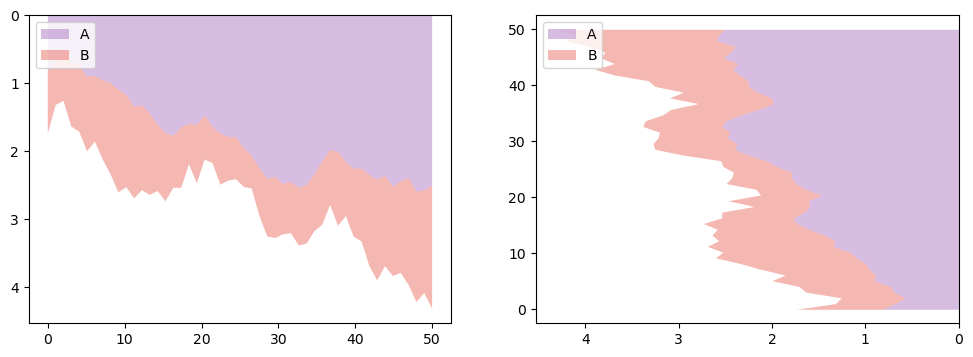

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

pal = ["#9b59b6", "#e74c3c"]
x = np.linspace(0, 3, num=50)
y1 = 1+np.random.uniform(-0.2, 0.21, x.size).cumsum()
y2 = 1+np.random.uniform(-0.3, 0.31, x.size).cumsum()
y = [y1, y2]
labels = ['A', 'B']

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

axs[0].stackplot(x, y, labels=labels, colors=pal, alpha=0.4)
axs[0].legend(loc='upper left')
axs[0].invert_yaxis()

yi_cum = 0
for yi, color, label in zip(y, pal, labels):
    axs[1].fill_betweenx(x, yi_cum, yi_cum + yi, color=color, label=label, alpha=0.4, lw=0)
    yi_cum += yi
axs[1].legend(loc='upper left')
axs[1].set_xlim(xmin=0)
axs[1].invert_xaxis()

plt.show()

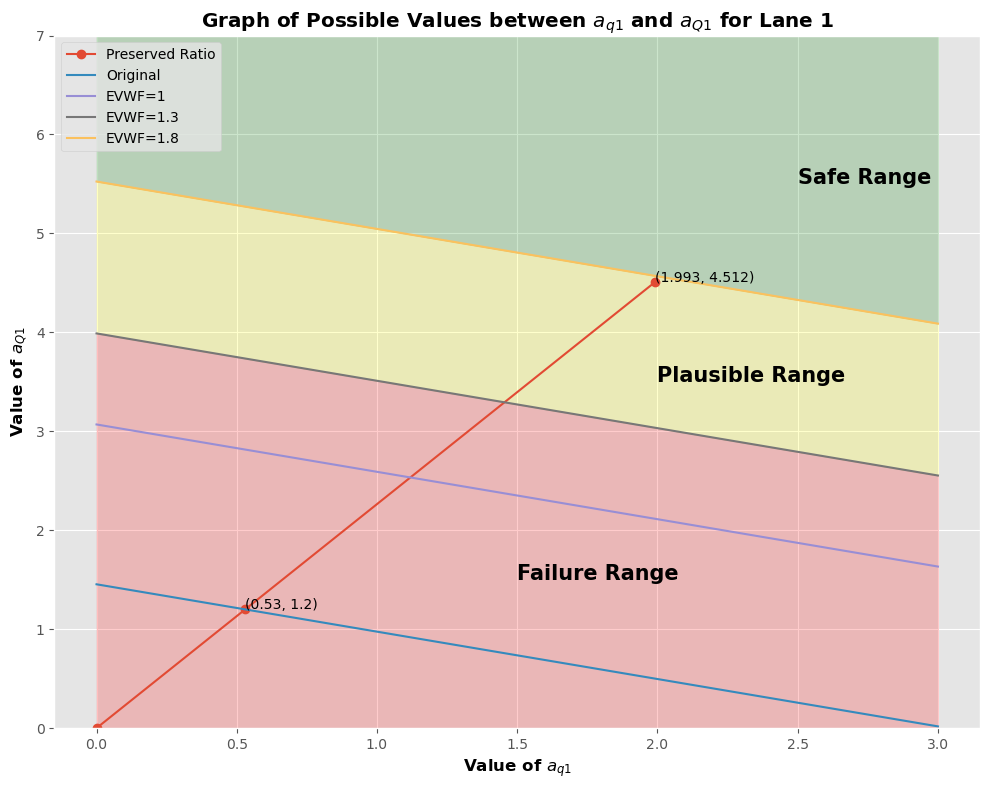

In [199]:
import matplotlib.pyplot as plt
import numpy as np


def f1(x):
    # output = (15 * 1366.5 - 750 * 9 * x) / (47 * 300)
    output = (1/940) * 1366.5 - (45/94) * x
    return output
def f2(x):
    # output = (15 * 2885 - 750 * 9 * x) / (47 * 300)
    output = (1/940) * 2885 - (45/94) * x
    return output
def f3(x):
    # output = (15 * 3750 - 750 * 9 * x) / (47 * 300)
    output = (1/940) * 3750 - (45/94) * x
    return output
def f4(x):
    # output = (15 * 5193 - 750 * 9 * x) / (47 * 300)
    output = (1/940) * 5193 - (45/94) * x
    return output

# pal = ["#9b59b6", "#e74c3c", 'green', 'blue']
plt.style.use('ggplot')
a_q = np.linspace(0, 3, num=50)
a_Q1 = np.array(list(map(f1, a_q)))
a_Q2 = np.array(list(map(f2, a_q)))
a_Q3 = np.array(list(map(f3, a_q)))
a_Q4 = np.array(list(map(f4, a_q)))
# y = [a_Q1, a_Q2, a_Q3, a_Q4]
labels = ['A', 'B','C','D']

# fig, axs = plt.subplots(ncols=1, figsize=(12, 4))

# plt.stackplot(x, y, labels=labels, colors=pal, alpha=0.4)
plt.figure(figsize=(10,8))
x2, y2 = [0,0.53,1.993], [0,1.2 ,4.512]
plt.plot( x2, y2, marker = 'o', label='Preserved Ratio')

plt.plot(a_q,a_Q1,label='Original')
plt.plot(a_q,a_Q2,label='EVWF=1')
plt.plot(a_q,a_Q3,label='EVWF=1.3')
plt.plot(a_q,a_Q4,label='EVWF=1.8')

plt.fill_between(a_q,a_Q3, alpha=0.2,color='red')
plt.fill_between(a_q,a_Q3,a_Q4, alpha=0.2,color='yellow')
plt.fill_between(a_q,a_Q4,7, alpha=0.2,color='green')


for xy in zip(x2, y2):                               
    if xy == (0,0):
        continue      # <--
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data',)

plt.annotate('Safe Range', xy=(2.5,5.5), textcoords='data',fontsize=15, weight='bold')
plt.annotate('Plausible Range', xy=(2,3.5), textcoords='data',fontsize=15, weight='bold')
plt.annotate('Failure Range', xy=(1.5,1.5), textcoords='data',fontsize=15, weight='bold')

# plt.title(r'W1 disk and central $\pm2^\circ$ subtracted', fontsize='small')
# plt.title(r'W1 disk and central $\pm2$ subtracted', fontsize='small')
plt.title(r'Graph of Possible Values between $a_{q1}$ and $a_{Q1}$ for Lane 1', weight='bold')
plt.xlabel(r'Value of $a_{q1}$', weight='bold', color='black')
plt.ylabel(r'Value of $a_{Q1}$', weight='bold', color='black')
plt.legend(loc='upper left')
plt.tight_layout()
plt.ylim(0,7)
# axs[0].ylim(bottom=0)
# axs[0].invert_yaxis()

# yi_cum = 0
# for yi, color, label in zip(y, pal, labels):
#     axs[1].fill_betweenx(x, yi_cum, yi_cum + yi, color=color, label=label, alpha=0.4, lw=0)
#     yi_cum += yi
# axs[1].legend(loc='upper left')
# axs[1].set_xlim(xmin=0)
# axs[1].invert_xaxis()

plt.show()

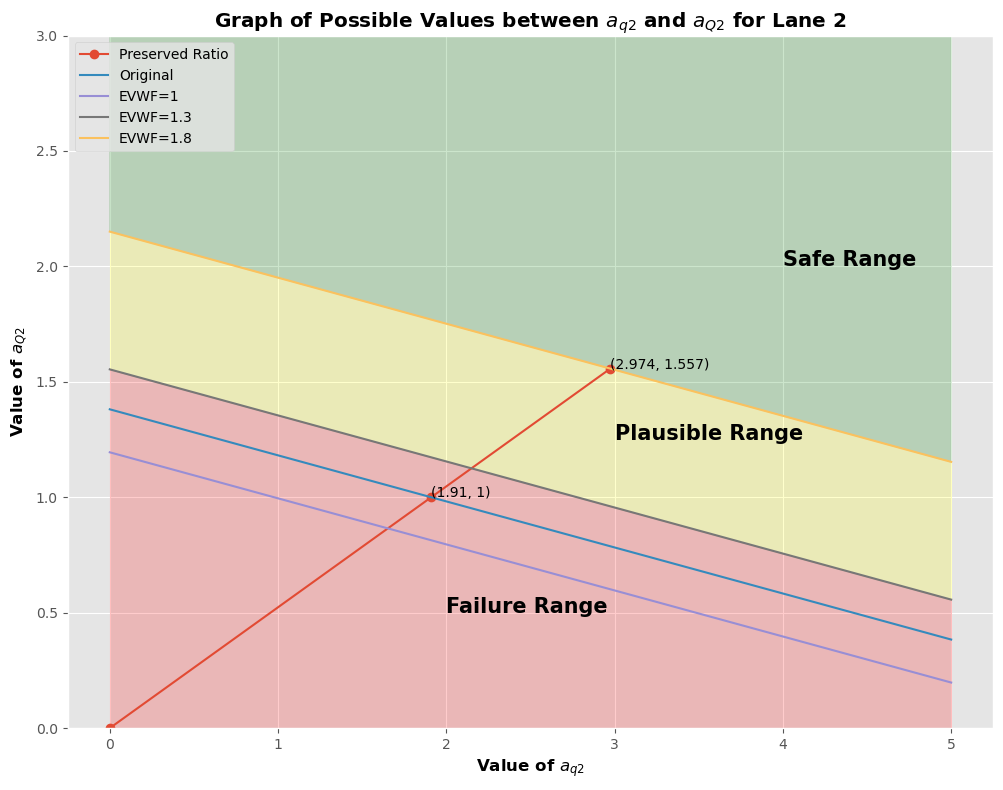

In [198]:
import matplotlib.pyplot as plt
import numpy as np


def f1(x):
    # output = (15 * 1366.5 - 750 * 9 * x) / (47 * 300)
    output = (6*(1115.958) - 3 * (1366.5) - 375 * x)/(9.4 * 200)
    return output
def f2(x):
    # output = (15 * 2885 - 750 * 9 * x) / (47 * 300)
    output = (6*(1816.86) - 3 * (2885) - 375 * x)/(9.4 * 200)
    return output
def f3(x):
    # output = (15 * 3750 - 750 * 9 * x) / (47 * 300)
    output = (6*(2361.92) - 3 * (3750) - 375 * x)/(9.4 * 200)
    return output
def f4(x):
    # output = (15 * 5193 - 750 * 9 * x) / (47 * 300)
    output = (6*(3270.36) - 3 * (5193) - 375 * x)/(9.4 * 200)
    return output

# pal = ["#9b59b6", "#e74c3c", 'green', 'blue']
plt.style.use('ggplot')
a_q = np.linspace(0, 5, num=50)
a_Q1 = np.array(list(map(f1, a_q)))
a_Q2 = np.array(list(map(f2, a_q)))
a_Q3 = np.array(list(map(f3, a_q)))
a_Q4 = np.array(list(map(f4, a_q)))
# y = [a_Q1, a_Q2, a_Q3, a_Q4]
labels = ['A', 'B','C','D']

# fig, axs = plt.subplots(ncols=1, figsize=(12, 4))

# plt.stackplot(x, y, labels=labels, colors=pal, alpha=0.4)
plt.figure(figsize=(10,8))
x2, y2 = [0,1.91,2.974], [0,1 ,1.557]
plt.plot( x2, y2, marker = 'o', label='Preserved Ratio')

plt.plot(a_q,a_Q1,label='Original')
plt.plot(a_q,a_Q2,label='EVWF=1')
plt.plot(a_q,a_Q3,label='EVWF=1.3')
plt.plot(a_q,a_Q4,label='EVWF=1.8')

plt.fill_between(a_q,a_Q3, alpha=0.2,color='red')
plt.fill_between(a_q,a_Q3,a_Q4, alpha=0.2,color='yellow')
plt.fill_between(a_q,a_Q4,7, alpha=0.2,color='green')


for xy in zip(x2, y2):                               
    if xy == (0,0):
        continue      # <--
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data',)

plt.annotate('Safe Range', xy=(4,2), textcoords='data',fontsize=15, weight='bold')
plt.annotate('Plausible Range', xy=(3,1.25), textcoords='data',fontsize=15, weight='bold')
plt.annotate('Failure Range', xy=(2,0.5), textcoords='data',fontsize=15, weight='bold')

# plt.title(r'W1 disk and central $\pm2^\circ$ subtracted', fontsize='small')
# plt.title(r'W1 disk and central $\pm2$ subtracted', fontsize='small')
plt.title(r'Graph of Possible Values between $a_{q2}$ and $a_{Q2}$ for Lane 2', weight='bold')
plt.xlabel(r'Value of $a_{q2}$', weight='bold', color='black')
plt.ylabel(r'Value of $a_{Q2}$', weight='bold', color='black')
plt.legend(loc='upper left')
plt.tight_layout()
plt.ylim([0,3])
# plt.xlim(0,5)
# axs[0].invert_yaxis()

# yi_cum = 0
# for yi, color, label in zip(y, pal, labels):
#     axs[1].fill_betweenx(x, yi_cum, yi_cum + yi, color=color, label=label, alpha=0.4, lw=0)
#     yi_cum += yi
# axs[1].legend(loc='upper left')
# axs[1].set_xlim(xmin=0)
# axs[1].invert_xaxis()

plt.show()

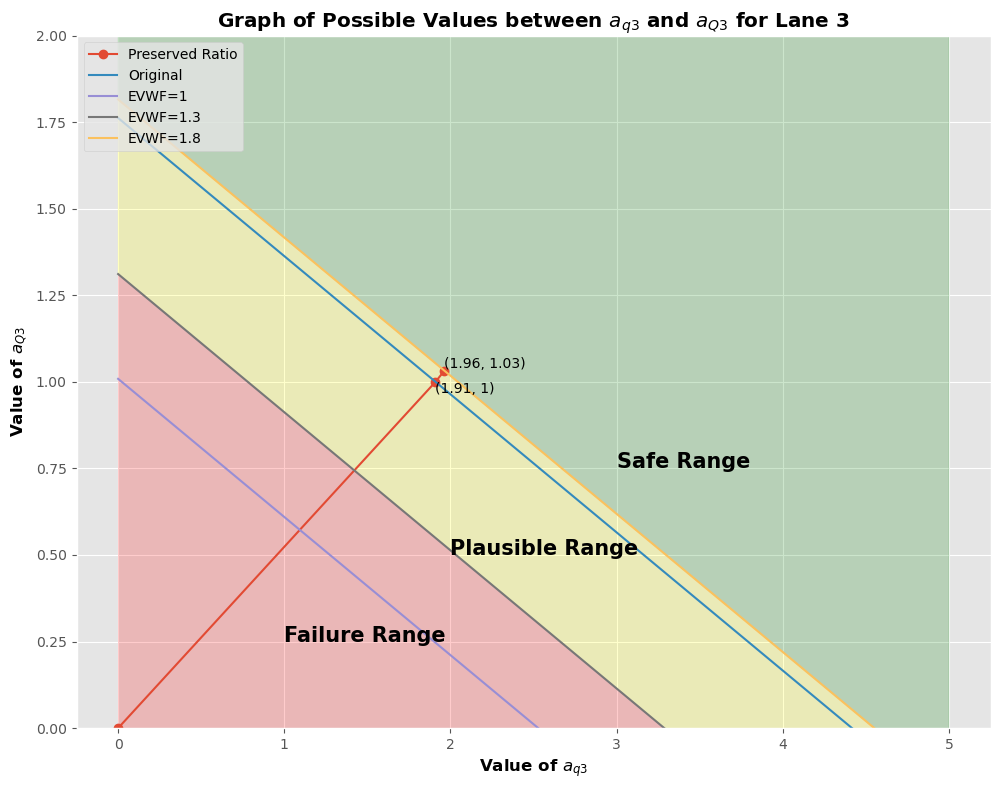

In [197]:
import matplotlib.pyplot as plt
import numpy as np

BM_EV_1 = 1316.59
BM_EV_1_3 = 1711.57
BM_EV_1_8 = 2369.86

def f1(x):
    # output = (15 * 1366.5 - 750 * 9 * x) / (47 * 300)
    output = 3*(3*(928)-2*(1115.9583)-125*x)/(9.4*100)
    return output
def f2(x):
    # output = (15 * 2885 - 750 * 9 * x) / (47 * 300)
    output = 3*(3*(BM_EV_1)-2*(1816.86)-125*x)/(9.4*100)
    return output
def f3(x):
    # output = (15 * 3750 - 750 * 9 * x) / (47 * 300)
    output = 3*(3*(BM_EV_1_3)-2*(2361.93)-125*x)/(9.4*100)
    return output
def f4(x):
    # output = (15 * 5193 - 750 * 9 * x) / (47 * 300)
    output = 3*(3*(BM_EV_1_8)-2*(3270.36)-125*x)/(9.4*100)
    return output

# pal = ["#9b59b6", "#e74c3c", 'green', 'blue']
plt.style.use('ggplot')
a_q = np.linspace(0, 5, num=50)
a_Q1 = np.array(list(map(f1, a_q)))
a_Q2 = np.array(list(map(f2, a_q)))
a_Q3 = np.array(list(map(f3, a_q)))
a_Q4 = np.array(list(map(f4, a_q)))
# y = [a_Q1, a_Q2, a_Q3, a_Q4]
labels = ['A', 'B','C','D']

# fig, axs = plt.subplots(ncols=1, figsize=(12, 4))

# plt.stackplot(x, y, labels=labels, colors=pal, alpha=0.4)
plt.figure(figsize=(10,8))
x2, y2 = [0,1.91,1.96], [0,1 ,1.03]
plt.plot( x2, y2, marker = 'o', label='Preserved Ratio')

plt.plot(a_q,a_Q1,label='Original')
plt.plot(a_q,a_Q2,label='EVWF=1')
plt.plot(a_q,a_Q3,label='EVWF=1.3')
plt.plot(a_q,a_Q4,label='EVWF=1.8')

plt.fill_between(a_q,a_Q3, alpha=0.2,color='red')
plt.fill_between(a_q,a_Q3,a_Q4, alpha=0.2,color='yellow')
plt.fill_between(a_q,a_Q4,7, alpha=0.2,color='green')


for xy in zip(x2, y2):                               
    if xy == (0,0):
        continue
    elif xy == (1.91,1):       # <--
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data',horizontalalignment='left', verticalalignment='top',)
    else:
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data', verticalalignment='bottom',)

plt.annotate('Safe Range', xy=(3,0.75), textcoords='data',fontsize=15, weight='bold')
plt.annotate('Plausible Range', xy=(2,0.5), textcoords='data',fontsize=15, weight='bold')
plt.annotate('Failure Range', xy=(1,0.25), textcoords='data',fontsize=15, weight='bold')

# plt.title(r'W1 disk and central $\pm2^\circ$ subtracted', fontsize='small')
# plt.title(r'W1 disk and central $\pm2$ subtracted', fontsize='small')
plt.title(r'Graph of Possible Values between $a_{q3}$ and $a_{Q3}$ for Lane 3', weight='bold')
plt.xlabel(r'Value of $a_{q3}$', weight='bold', color='black')
plt.ylabel(r'Value of $a_{Q3}$', weight='bold', color='black')
plt.legend(loc='upper left')
plt.tight_layout()
plt.ylim(0,2)
# plt.xlim(0,5)
# axs[0].invert_yaxis()

# yi_cum = 0
# for yi, color, label in zip(y, pal, labels):
#     axs[1].fill_betweenx(x, yi_cum, yi_cum + yi, color=color, label=label, alpha=0.4, lw=0)
#     yi_cum += yi
# axs[1].legend(loc='upper left')
# axs[1].set_xlim(xmin=0)
# axs[1].invert_xaxis()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


   Class  Lane = 1   Lane = 2 
0      1   0.000732   0.000173
1      2   0.476270   0.654654
2      3   0.037017   0.022848
3      4   0.038087   0.086579
4      5   0.031162   0.049330
5      6   0.067476   0.062623
6      7   0.250281   0.086544
7      8   0.075723   0.035241
8      9   0.023252   0.002008
   Class  Lane = 1   Lane = 2   Lane = 3 
0      1   0.000732   0.000173   0.000606
1      2   0.476270   0.654654   0.901953
2      3   0.037017   0.022848   0.013728
3      4   0.038087   0.086579   0.055303
4      5   0.031162   0.049330   0.008661
5      6   0.067476   0.062623   0.005067
6      7   0.250281   0.086544   0.005543
7      8   0.075723   0.035241   0.007882
8      9   0.023252   0.002008   0.001256
       Lane = 1   Lane = 2   Lane = 3 
Class                                 
1       0.000732   0.000173   0.000606
2       0.476270   0.654654   0.901953
3       0.037017   0.022848   0.013728
4       0.038087   0.086579   0.055303
5       0.031162   0.049330   0.0086

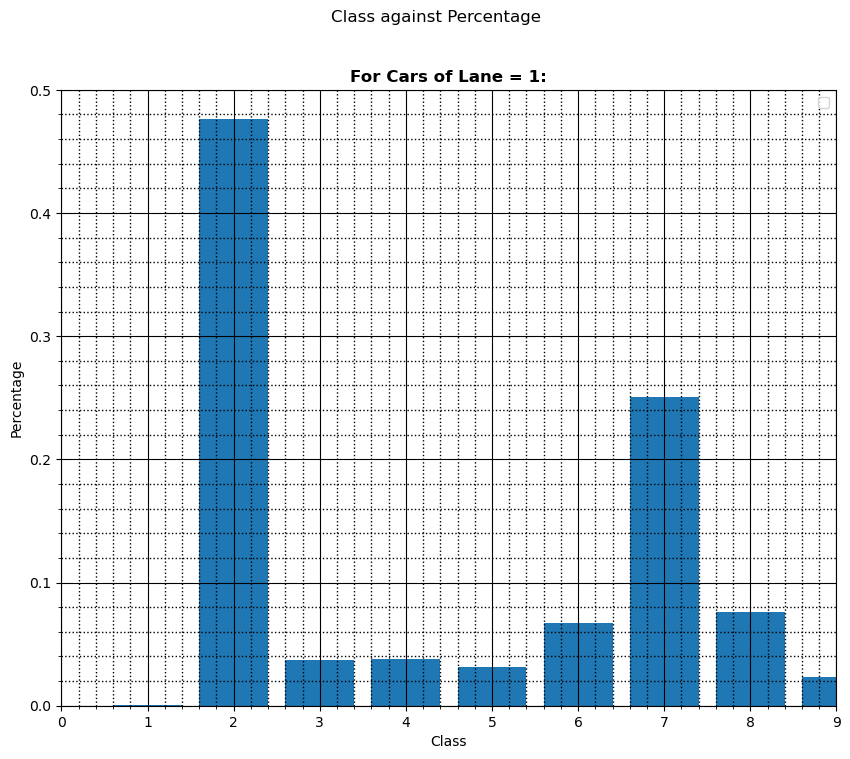

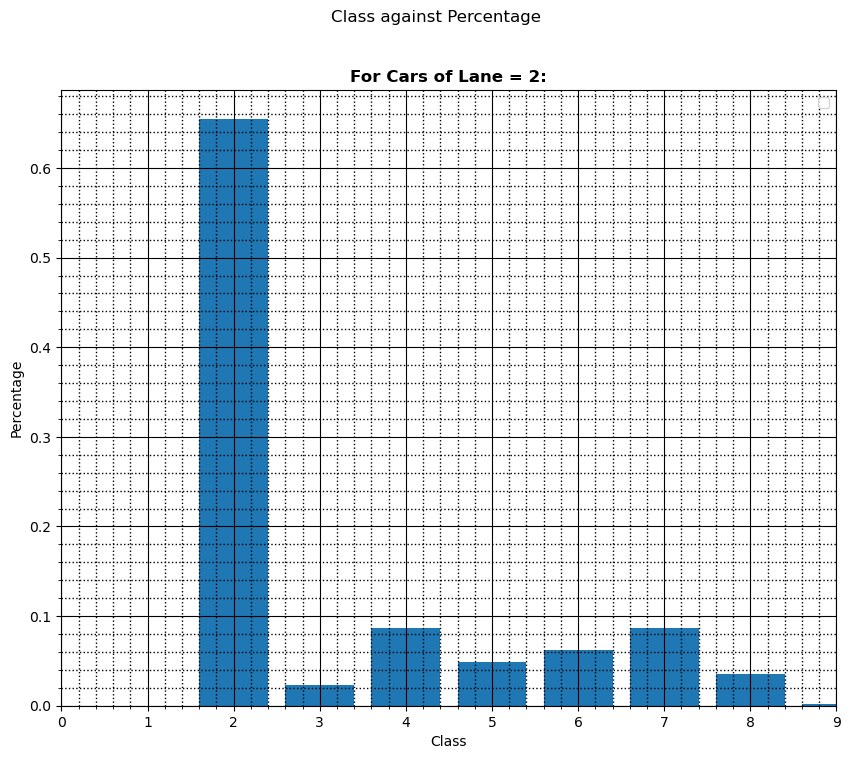

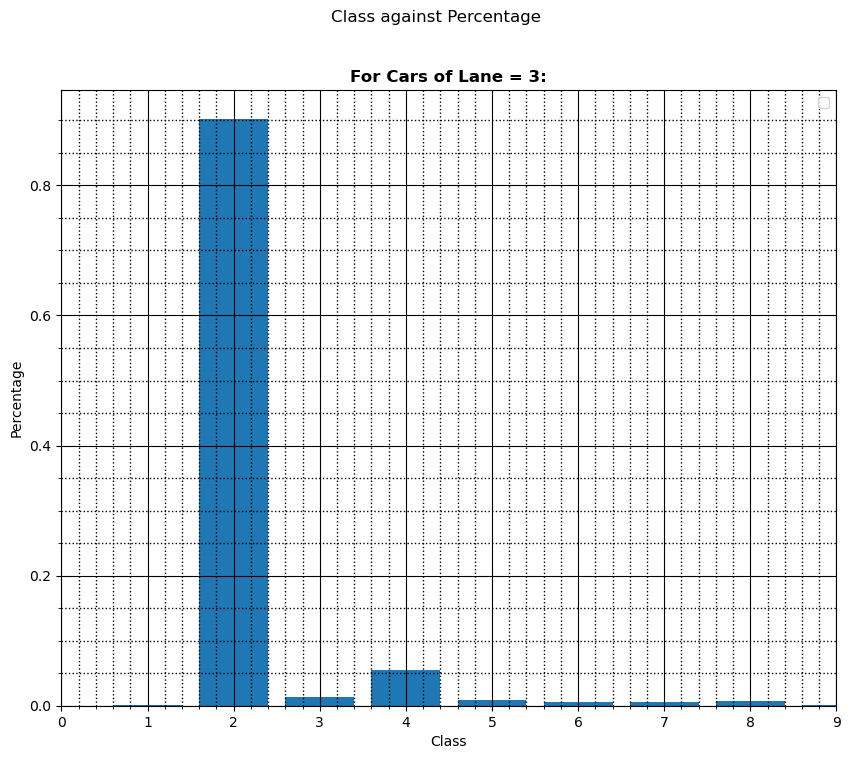

<Figure size 1000x800 with 0 Axes>

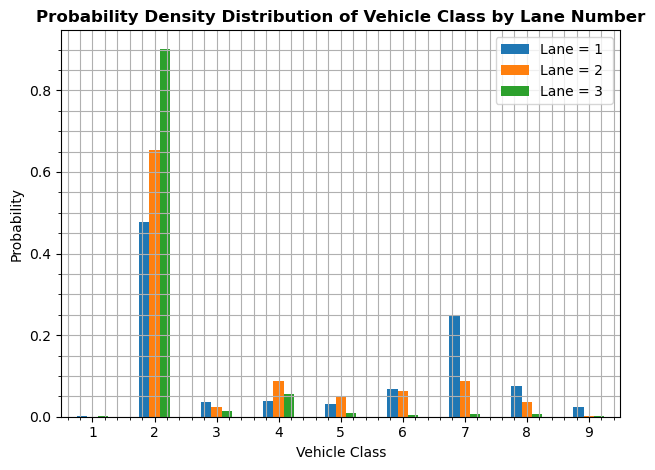

In [176]:
for lane in range(1,4):
    generate_variable('Lane', lane, 'Class')

# database.keys()

database.keys()
plt.figure(figsize=(10,8))
output = 0
for key in ['Lane = 1 Class', 'Lane = 2 Class', 'Lane = 3 Class']:
    distribution = database[key]
    distribution = distribution.rename(columns={'Percentage': key[:9]})

    if type(output)==int:
        output = distribution
    else: 
        output = pd.concat([output,distribution.iloc[:,-1]],axis=1)
        print(output)
    # plt.plot(distribution.iloc[:,0], distribution.iloc[:,-1],'.-', label=key[:9])
output = output.set_index('Class')
print(output)
output.plot(kind='bar',rot=0)
plt.style.use('default')
plt.title('Probability Density Distribution of Vehicle Class by Lane Number',fontweight="bold")
plt.ylabel('Probability')
# plt.ylabel('Cumulative Probability')
# plt.xlabel('Total Weight (kg)')
plt.xlabel('Vehicle Class')
plt.minorticks_on()
plt.tight_layout()
plt.grid(which='both')
plt.legend()
plt.show()